# 1K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of a proprietary, difunctional polyol from Dow Chemical with molecular weight ~1000 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 12-17, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 30.5 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc
import errprop
import plot

from importlib import reload
reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190613_0614_1k2f_30c_adsa_volume.csv', '20190614_0617_1k2f_30c_adsa_volume.csv']
# list of data files with interfacial tension data
adsa_if_tension_file_list = ['20190613_0614_1k2f_30c_adsa_if_tension.csv', '20190614_0617_1k2f_30c_adsa_if_tension.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/1k2f_30c-TRD-061219-1804.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '1k2f_30c.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/12 6:05:58pm; adsa video 1 6/12 6:16pm, adsa video2 6/14 7:02pm
adsa_t0_list = [3600*25 + 60*8 + 2, 24*3600*2 + 60*56 + 2]
# number of measurements to average for surface tension and volume readings
n_adsa = 5

# code name for polyol
polyol = '1k2f'
# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.686
# volume of drop in atmosphere (use snapshot taken in atmosphere before put in vacuum) w/ calibration 8572.1 nm/pixel [uL]
# previously used 8585.2 nm/pixel, which resulted in an estimate of 3.57 uL, which was larger than the drop volumes
# measured at the end of the experiment, where the calibration was 8572.1 nm/pixel
v_drop_atm = 3.552 
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS) [g/mL]
rho_samp_atm = 1.02 
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.26735 # extrpolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of just the crucible at atmospheric pressure [g]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
                       5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
                       280, 230, 180, 130, 80])
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# number of measurements of pressure within equilibrium (300 s, every 30 s)
n_p_eq = 10

# CONSTANTS
# Set-point temperature [C]
T = 30.5
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = br_cruc + dataproc.rho_co2(P_ATM, T)*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [6]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, \
                                                                                      adsa_t0_list, grav_file_path, p_set_arr)
df.head()

p set [kPa] p actual [kPa] p std [kPa] zero [g] zero std [g] mp1 [g]  \
0            0            NaN         NaN      NaN          NaN     NaN   
1          500            NaN         NaN      NaN          NaN     NaN   
2         1000            NaN         NaN      NaN          NaN     NaN   
3         1500            NaN         NaN      NaN          NaN     NaN   
4         2000            NaN         NaN      NaN          NaN     NaN   

  mp1 std [g] mp2 [g] mp2 std [g] M_0 (extrap) [g]  ...  \
0         NaN     NaN         NaN              NaN  ...   
1         NaN     NaN         NaN              NaN  ...   
2         NaN     NaN         NaN              NaN  ...   
3         NaN     NaN         NaN              NaN  ...   
4         NaN     NaN         NaN              NaN  ...   

  dissolved gas balance reading [g] buoyancy correction [g]  \
0                               NaN                     NaN   
1                               NaN                     NaN   
2                               NaN                     NaN   
3                               NaN                     NaN   
4                               NaN                     NaN   

  actual weight of dissolved gas [g] solubility [w/w] solubility error [w/w]  \
0                                NaN              NaN                    NaN   
1                                NaN              NaN                    NaN   
2                                NaN              NaN                    NaN   
3                                NaN              NaN                    NaN   
4                                NaN              NaN                    NaN   

  specific volume [mL/g] specific volume error [mL/g]  \
0                    NaN                          NaN   
1                    NaN                          NaN   
2                    NaN                          NaN   
3                    NaN                          NaN   
4                    NaN                          NaN   

  diffusivity (sqrt) [cm^2/s] diffusivity (exp) [cm^2/s]  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         NaN                        NaN   
3                         NaN                        NaN   
4                         NaN                        NaN   

  diffusion time constant [s]  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  

[5 rows x 28 columns]

## Synchronize Gravimetry and ADSA Measurements
### Masses and Volumes First--Interfacial Tension Later

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and drop volume (and take the standard deviation as an estimate of the error) and save them for further analysis. We do not analyze the interfacial tension because we need to estimate the density of the drop at each pressure and enter the value in the FTA32 software for computing the interfacial tension of the pendant drop images.

Pressure = 0 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


********not enough ADSA points at given pressure.******
Drop volume = nan uL.
Pressure = 500 kPa.

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Rejected 1 outliers.
Drop volume = 3.566400 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.
Drop volume = 3.624200 uL.
Pressure = 1500 kPa.
Rejected 1 outliers.
Drop volume = 3.703000 uL.
Pressure = 2000 kPa.
Rejected 1 outliers.
Drop volume = 3.793400 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Drop volume = 3.869000 uL.
Pressure = 3000 kPa.
Rejected 1 outliers.
Drop volume = 3.928000 uL.
Pressure = 3500 kPa.
Rejected 1 outliers.
Drop volume = 4.037800 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Drop volume = 4.127400 uL.
Pressure = 4500 kPa.
Rejected 1 outliers.
Drop volume = 4.225200 uL.
Pressure = 5000 kPa.
Rejected 1 outliers.
Drop volume = 4.367400 uL.
Pressure = 5500 kPa.
Rejected 1 outliers.
Drop volume = 4.460800 uL.
Pressure = 4650 kPa.
Rejected 1 outliers.
Drop volume = 4.270000 uL.
Pressure = 3900 kPa.
Rejected 1 outliers.
Drop volume = 4.112600 uL.
Pressure = 3150 kPa.
Rejected 1 outliers.
Drop volume = 3.971400 uL.
Pressure = 2400 kPa.
Rejected 1 outliers.
Drop volume 

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Drop volume = 3.576800 uL.
Pressure = 230 kPa.
Rejected 1 outliers.
Drop volume = 3.575400 uL.
Pressure = 180 kPa.
Rejected 1 outliers.
Drop volume = 3.561000 uL.
Pressure = 130 kPa.
Rejected 1 outliers.
Drop volume = 3.569200 uL.
Pressure = 80 kPa.
Drop volume = 3.555600 uL.


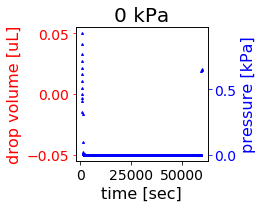

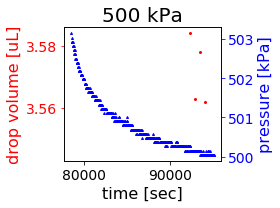

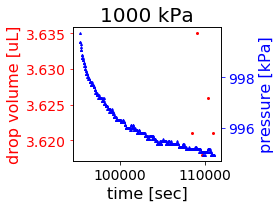

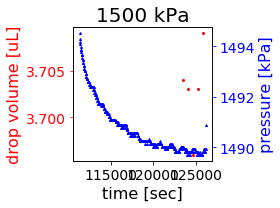

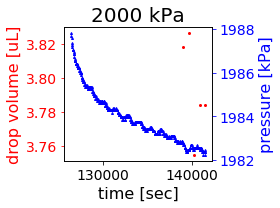

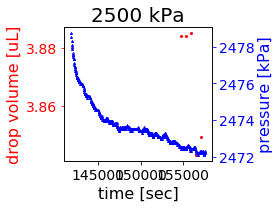

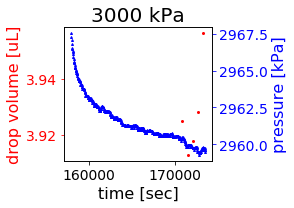

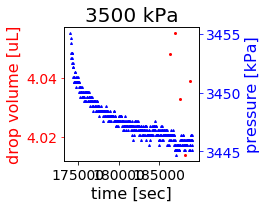

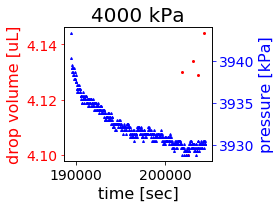

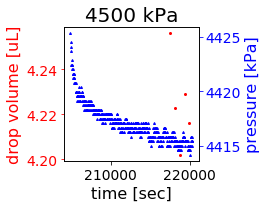

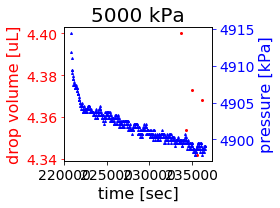

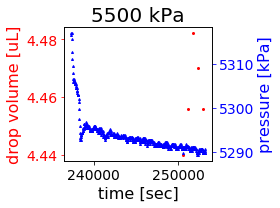

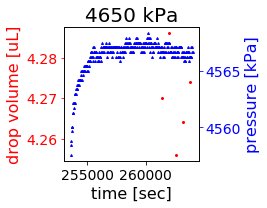

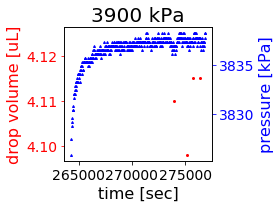

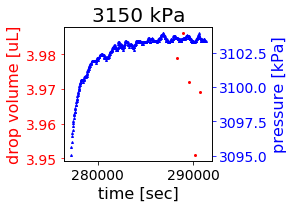

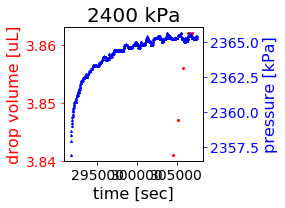

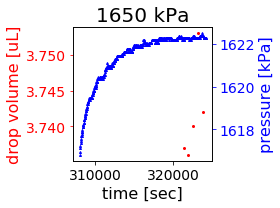

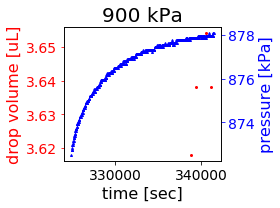

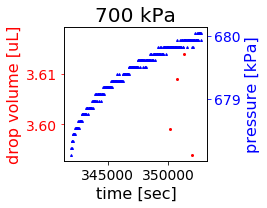

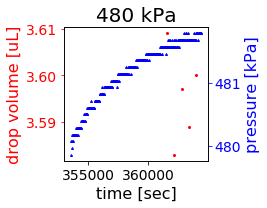

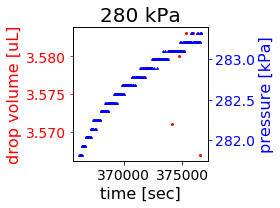

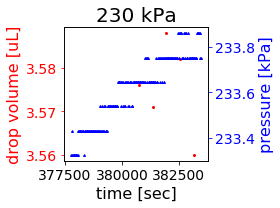

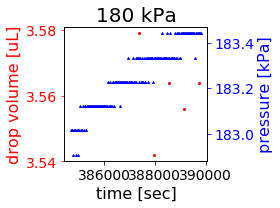

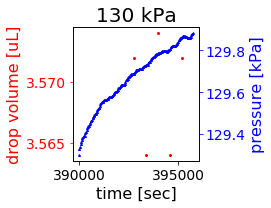

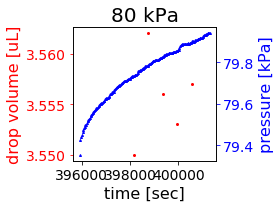

In [7]:
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization

# initalize marker for pressure bounds
i_p1 = 0
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
    # Shift initial index if there are more points to the final index than required for equilibrium pressure measurement
    i_p0_shifted = max(i_p0, i_p1-n_p_eq)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[i_p0_shifted:i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = np.std(p_eq)
    # store results in data frame; use times to determine indices of ADSA to use
    i_adsa = dataproc.get_inds_adsa(t_adsa, t_grav, i_p0, i_p1, n_adsa)
    
    # plot drop volume measurements alongside pressure
    plot.plot_two_axes(t_adsa[i_adsa], v_drop[i_adsa], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['drop vol', 'p'], xlabel='time [sec]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='%d kPa' % p_set)
    
    # store results in data frame
    df = dataproc.store_grav_adsa(df, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_adsa)
    
# correct error in zero measurement at 130 kPa--2 measurements, -0.00218, -0.00217 [g]
df['zero [g]'].loc[23] = -0.002175
df['zero std [g]'].loc[23] = 0.00001

**We see above that the pressure spiked at 5500 kPa (a limitation of the gas cylinder in providing 5500 kPa), which may explain the kink in the sorption curve that we see below at that pressure.**
However, in general the pressure remained within about 10 kPa of the average value (which was not necessarily the set value).

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility and specific volume. With the specific volume, we take the reciprocal to get the density, a required input to compute the interfacial tension of the pendant drops using the FTA32 software.

#### Ad Hoc Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum. For this experiment, I lost the image of the drop under vacuum, so I must estimate the mass and volume of the polyol under vacuum by extrapolating from atmospheric measurements of mass and density. However, since I don't have Rubotherm measurements at atmospheric pressure, I extrapolated the mass between the masses at 80 kPa and 130 kPa. I then estimated the volume by assuming the same mass density as at atmospheric pressure.

In [8]:
# Because I am missing a measurement of the volume of the drop in vacuum, I must estimate
# the mass of the dry polymer in the following ad hoc manner:

# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# sample volume at atmospheric pressure [mL]
v_samp_atm = w_samp_atm / rho_samp_atm
# buoyant force correction at 130 kPa (pressure step at index -2) [g]
i_130kPa = np.where(p_set_arr==130)[0]
w_buoy_130kPa = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float)[i_130kPa], T)*(v_samp_atm + v_ref_he)
br_gas_130kPa = br_gas[i_130kPa]
# weight of adsorbed gas at 130 kPa (buoyancy-corrected) [g]
w_gas_130kPa = br_gas_130kPa + w_buoy_130kPa

# buoyant force correction at 80 kPa (pressure step at index -1) [g]
i_80kPa = np.where(p_set_arr==80)[0]
w_buoy_80kPa = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float)[i_80kPa], T)*(v_samp_atm + v_ref_he)
br_gas_80kPa = br_gas[i_80kPa]
# weight of gas at 80 kPa (buoyancy-corrected) [g]
w_gas_80kPa = br_gas_80kPa + w_buoy_80kPa

# APPROXIMATE weight of gas at atmosphere with linear interpolation [g]
w_gas_atm = w_gas_80kPa + (w_gas_130kPa - w_gas_80kPa)*(P_ATM - 80)/(130 - 80)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE - df['zero [g]'][0]
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# APPROXIMATE volume of dry (vacuum) sample using density at atmospheric pressure [mL]
v_poly = w_poly / rho_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

Dry polymer mass from ad hoc extrap = 0.684546 g vs. mass of polymer at atmospheric pressure = 0.686000 g.
Dry polymer mass estimated using tare measurement = 0.6843395953541513 g.
Volume of dry polymer in crucible is approximately ~ 0.670921 mL (using atmospheric density).


The two estimation methods above (ad hoc and tare-based) almost exactly agree. Since the tare-based method involves fewer approximations, we adopt it to estimate the weight of the dry polyol (`w_poly`).

### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

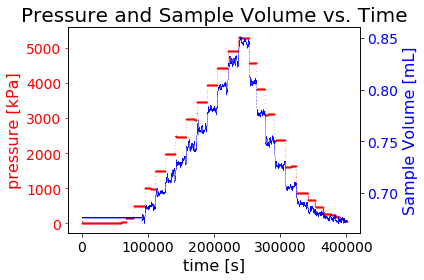

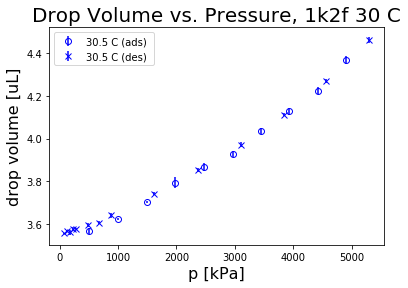

In [9]:
# Load equilibrium drop volume from dataframe [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to extrapolate sample volume and store results
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# compute live change in volume at each gravimetry measurement (more frequent than ADSA measurements)
v_samp_adsa = v_drop / v_drop_atm * v_samp_atm
v_samp_grav = np.interp(t_grav, t_adsa, v_samp_adsa)
# plot pressure alongside interpolated sample volume
plot.plot_two_axes(t_grav, p_arr, v_samp_grav, labels=[r'$p$', r'$V_{samp}$'], xlabel='time [s]', 
                   ms=0.1, ylabels=['pressure [kPa]', 'Sample Volume [mL]'], title='Pressure and Sample Volume vs. Time')

# extract drop volume data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
s_drop_vol = df['drop volume std [uL]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))

# save drop volume figure
if save_plots:
    plt.savefig(save_folder + 'drop_vol_1k2f_30C.pdf', bbox_inches='tight')

#### Fitting Drop Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the drop volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the drop volume, we will reduce the error in the sample volume, and thus in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*

This method greatly reduces the statistical error, but leaves the non-negligible systematic error unchanged.

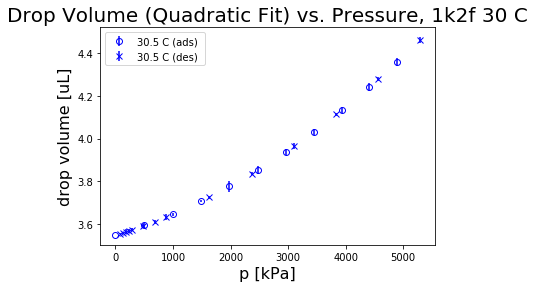

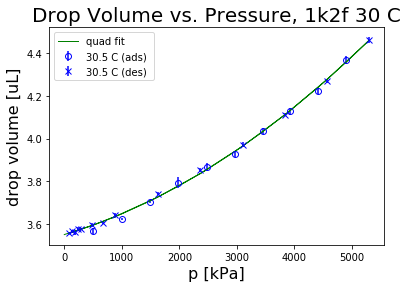

In [11]:
# remove nans to leave only data formatted appropriate for fitting methods
inds_not_nan = np.logical_not(np.isnan(s_drop_vol))
p_plot_2_fit = p_plot[inds_not_nan]
v_drop_eq_2_fit = v_drop_eq[inds_not_nan]
s_drop_vol_2_fit = s_drop_vol[inds_not_nan]

# fit drop volume vs. pressure with quadratic (2nd-degree) fit
i_sort = np.argsort(p_plot[1:])
coeffs, Cov = np.polyfit(p_plot_2_fit, v_drop_eq_2_fit, 2, w=1/s_drop_vol_2_fit, cov=True)
a, b, c = coeffs
# compute fitted values of drop volume [uL]
v_drop_fit = a*p_plot**2 + b*p_plot + c

# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_fit, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot equilibrium drop volume vs. p alongside the fit (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot, v_drop_fit, ax=ax, marker=None, lw=1, color='g', label='quad fit')

plt.legend()
# Compute sample volume based on fitted drop volume
v_samp_fit = v_drop_fit / v_drop_atm * v_samp_atm


### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [12]:
reload(errprop)

# set parameters for error propagation ***Note that s_<variable> is the uncertainty/std deviation of <variable>
n = len(p_set_arr[1:]) # number of data points to consider
w_poly_arr = w_poly*np.ones([n]) # array of polyol weight value
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)[1:]
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)[1:]/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)[1:]  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_eq[-2]*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop[-2]*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)[1:]
s_zero = df['zero std [g]'].to_numpy(dtype=float)[1:]
s_w_gas_ref = 0.00001*np.ones([n]) # uncertainty in reference adsorbed gas measurement = error in Rubotherm (10 ug) [g]

#### Plot adsorbed gas mass over time.

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4650 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3900 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3150 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2400 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1650 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Rejected 1 out

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Pressure = 130 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 80 kPa.


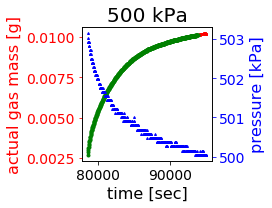

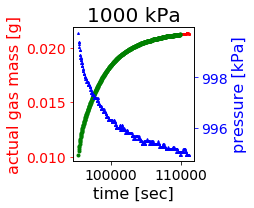

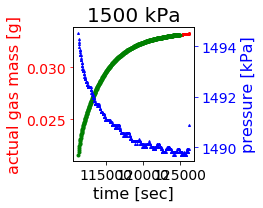

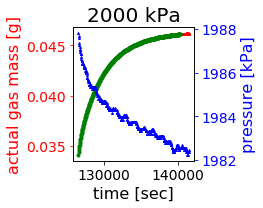

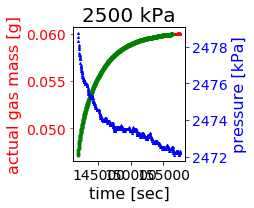

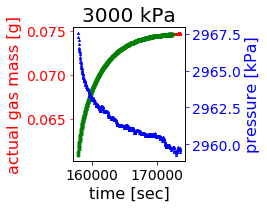

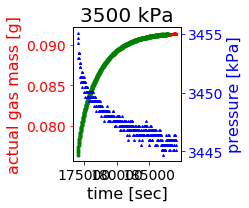

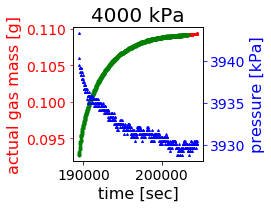

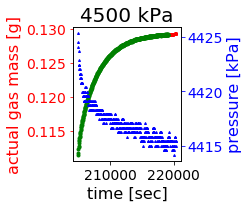

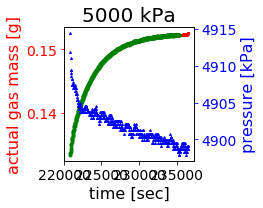

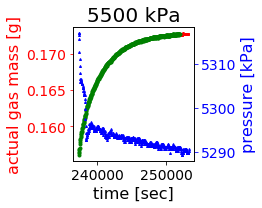

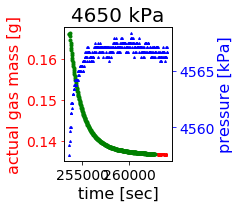

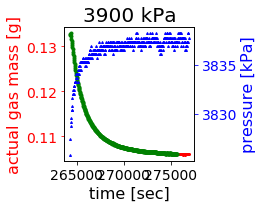

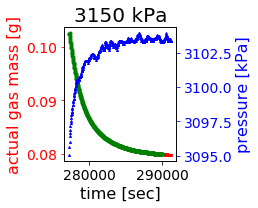

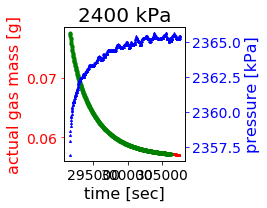

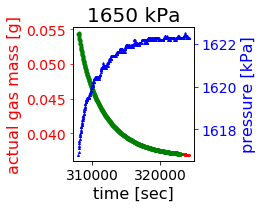

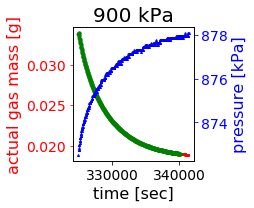

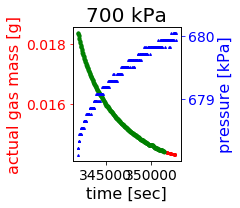

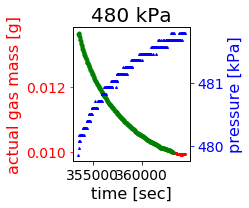

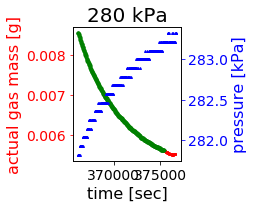

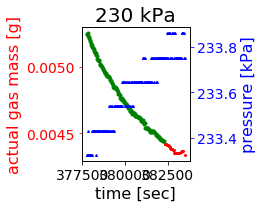

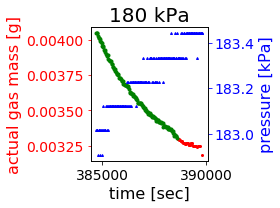

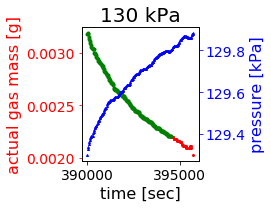

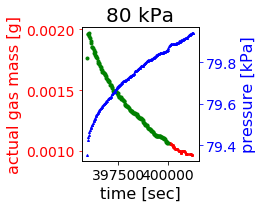

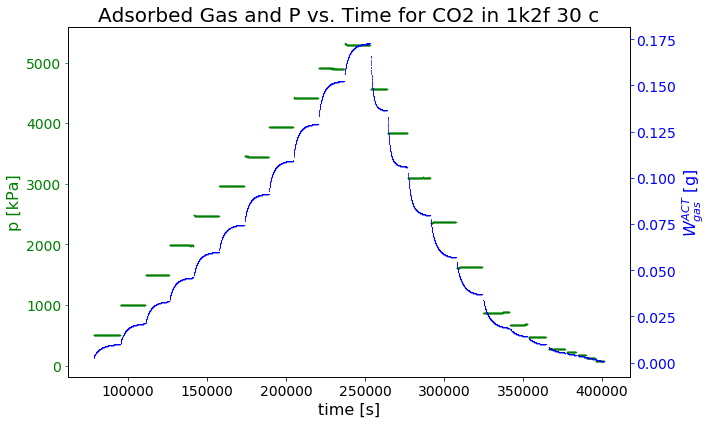

In [13]:
reload(plot)
reload(dataproc)
# number of seconds to define equilibrium
n_sec = 1200
# initalize marker for pressure bounds
last_bound = 0
# initialize arrays to store data
t_mp1_arr = np.array([])
w_gas_act_arr = np.array([])
p_mp1_arr = np.array([])
M_0_prev = np.zeros([len(p_set_arr)])
M_infty_final = np.zeros([len(p_set_arr)])

# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # use a higher threshold on the fractional pressure fluctuation for 20 kPa
    if p_set == 20:
        p_thresh_frac_20 = 0.1
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac_20, last_bound=last_bound)
        # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
        w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                            t_grav, p_thresh_frac_20, last_bound, v_ref_he, 
                                                                            get_inst_buoy=True)
    else:
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
        # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
        w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                            t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                            get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # concatenate results to arrays
    t_mp1_arr = np.concatenate((t_mp1_arr, t_mp1))
    w_gas_act_arr = np.concatenate((w_gas_act_arr, w_gas_act))
    p_mp1_arr = np.concatenate((p_mp1_arr, p_mp1))
    # get indices to average the last given number of seconds
    inds_eq = np.where(t_mp1[-1] - t_mp1 <= n_sec)[0]
    inds_trans = np.where(t_mp1[-1] - t_mp1 > n_sec)[0]
    w_gas_act_eq = np.mean(w_gas_act[inds_eq])
    
    # plot dissolved gas for each pressure on same plot
    ax = plot.plot_two_axes(t_mp1[inds_eq], w_gas_act[inds_eq], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['gas mass', 'p'], xlabel='time [sec]', ms=2, 
                   ylabels=['actual gas mass [g]', 'pressure [kPa]'], title='%d kPa' % p_set)
    plot.plot_line(t_mp1[inds_trans], w_gas_act[inds_trans], color='g', ax=ax)
    
    # save equilibrium values
    df['actual weight of dissolved gas [g]'].iloc[i] = w_gas_act_eq
    
    # save gas mass from current run for next M_0
    if i < len(p_set_arr)-1:
        M_0_prev[i+1] = w_gas_act_eq
    # save gas mass from current run for current M_infty
    M_infty_final[i] = w_gas_act_eq
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue

# save initial mass estimated using previous gas mass [g]
df['M_0 (prev) [g]'] = M_0_prev
# save final gas mass [g]
df['M_infty (final) [g]'] = M_infty_final

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_mp1_arr, p_mp1_arr, w_gas_act_arr, markers=['o', '^'], labels=['p', r'$w_{gas}$'], figsize=(10,6),
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=['g', 'b'], ms=0.2,
                       xlabel='time [s]', ylabels=['p [kPa]', r'$W_{gas}^{ACT}$ [g]'])

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

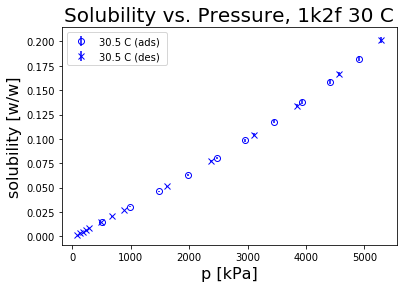

In [14]:
# COMPUTE AND PLOT SOLUBILITY

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_buoy = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float), T)*(v_samp + v_ref_he)
df['buoyancy correction [g]'] = w_buoy
w_gas_act = br_gas + w_buoy
df['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility--drop the values at 0 pressure because ADSA data were not saved
s_solubility = errprop.error_solubility(solubility[1:], v_samp[1:], w_buoy[1:], w_gas_act[1:], v_drop_eq[1:], 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
s_solubility = np.concatenate((np.array([np.nan]), s_solubility))
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Dow Data

Since Dow has provided data on this polyol in the Sharepoint folder at 25 C and 60 C, we will plot the solubility alongside it.

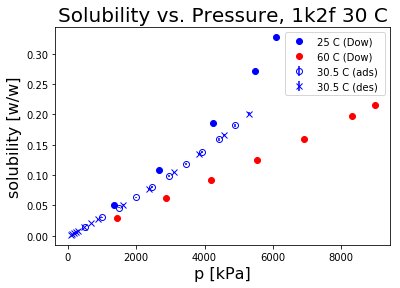

In [15]:
# plot data from Dow (Jacob Crosthwaite) at 25 C and 60 C on VORANOL 2110B
psi2kPa = 6.8948
p_dow_25 = np.array([193.5, 388.7, 614.8, 795.1, 881.5])*psi2kPa
solubility_dow_25 = np.array([0.0509, 0.1088, 0.1865, 0.2711, 0.3273])
p_dow_60 = np.array([206.7, 414.5, 606.1, 802.7, 1002.7, 1207.8, 1304.1])*psi2kPa
solubility_dow_60 = np.array([0.0299, 0.0617, 0.0924, 0.1253, 0.1602, 0.1974, 0.2152])

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_dow_25, solubility_dow_25, ax=ax, marker='o', color='b', label='25 C (Dow)')
ax = plot.plot_line(p_dow_60, solubility_dow_60, ax=ax, marker='o', color='r', label='60 C (Dow)')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_dow_data.pdf' % (polyol, T), bbox_inches='tight')

#### Comparison to Yang et al. (2019)

Yang *et al.* (2019), *Journal of Chemical Thermodynamics*, measured solubility of CO2 in different polyols, including a 1000 g/mol difunctional polyol with the same hydroxyl number (110 mg KOH / g) as VORANOL 2110B (although its name is P1010). Though the measurement was made at 35 C, we compare our measurements of CO2 in VORANOL 2110B at 30.5 C below.

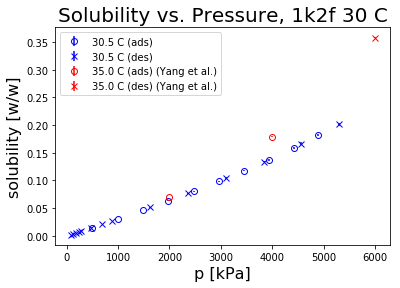

In [16]:
# Data points from p. 31 of Yang et al. JCT (2019)
p_yang = np.array([2000, 4000, 6000])
solub_yang = np.array([0.0703, 0.1787, 0.3582])
s_solub_yang = np.array([0.0003, 0.0008, 0.0008])

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_yang, solub_yang, s_solub_yang, p_yang, 35, color='r', ax=ax, label_tag='(Yang et al.)')

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_yang_35c.pdf' % (polyol, T), bbox_inches='tight')

**Our results do not match those of Yang et al.,** which predict a higher solubility despite being performed at a higher temperaure, which should reduce the solubility.

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

(0.95, 1.05)

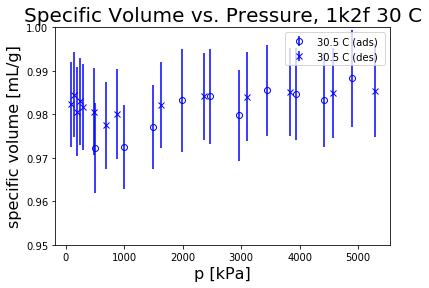

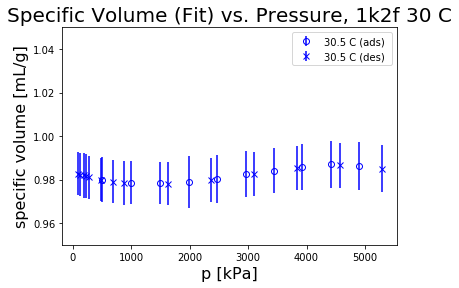

In [17]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)

# propagate error to estimate uncertainty
s_spec_vol = errprop.error_spec_vol(spec_vol[1:], v_samp[1:], w_buoy[1:], w_gas_act[1:], v_drop_eq[1:], 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
s_spec_vol = np.concatenate((np.array([np.nan]), s_spec_vol))
df['specific volume error [mL/g]'] = s_spec_vol

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.95, 1.0])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol_fit, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                             ylabel='specific volume [mL/g]', title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.95, 1.05])

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

**With quadratic fit of drop volume, the non-monotonicity in the specific volume becomes very apparent where it was indistinguishable before--could this mean that the non-monotonicity is an artifact of the quadratic fitting? Or is the quadratic fit essential to remove enough noise to see the non-monotonicity?**

*The quadratic fit does not seem to introduce non-monotonicity as an artifact--see the powerpoint "20190827_quadratic_fit_nonmonotonic_spec_vol.ppt" for demonstration.*

Now we store results.

In [18]:
reload(dataproc)
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

### Interfacial Tension

At this point, I use the program auto_density_input_fta32.py to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 0 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
Interfacial tension data not stored.
Pressure = 500 kPa.
Rejected 1 outliers.
Interfacial tension = 24.372000 mN/m.
Pressure = 1000 kPa.
Rejected 1 outliers.
Interfacial tension = 23.288000 mN/m.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 1500 kPa.
Rejected 1 outliers.
Interfacial tension = 22.056000 mN/m.
Pressure = 2000 kPa.
Rejected 1 outliers.
Interfacial tension = 20.614000 mN/m.
Pressure = 2500 kPa.
Rejected 1 outliers.
Interfacial tension = 19.438000 mN/m.
Pressure = 3000 kPa.
Rejected 1 outliers.
Interfacial tension = 18.170000 mN/m.
Pressure = 3500 kPa.
Rejected 1 outliers.
Interfacial tension = 16.702000 mN/m.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 15.246000 mN/m.
Pressure = 4500 kPa.
Rejected 1 outliers.
Interfacial tension = 13.762000 mN/m.
Pressure = 5000 kPa.
Rejected 1 outliers.
Interfacial tension = 12.206000 mN/m.
Pressure = 5500 kPa.
Rejected 1 outliers.
Interfacial tension = 10.940000 mN/m.
Pressure = 4650 kPa.
Rejected 1 outliers.
Interfacial tension = 13.320000 mN/m.
Pressure = 3900 kPa.
Rejected 1 outliers.
Interfacial tension = 15.460000 mN/m.
Pressure = 3150 kPa.
Rejected 1 outliers.
Interfacial tension = 17.632000 mN/m.
Pressure = 2400 kPa.
Rejected 1 outliers

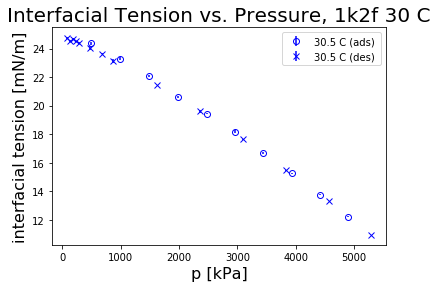

In [19]:
reload(dataproc)
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # save results
    df.to_csv(save_folder + save_data_name)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))
    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$. **Note that $t_0^{fit}$ is the same as $t_0$ but is a** ***fitted parameter*** **rather than a mathematical variable.**

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Analysis that follows in the next section shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

In [27]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:500, 2:1000, 3:1500, 4:2000, 5:2500, 6:3000, 7:3500, 8:4000, 9:4500,
#                        10:5000, 11:5500, 12:4650, 13:3900, 14:3150, 15:2400, 16:1650, 17:900, 18:700, 19:480, 
#                        20:280, 21:230, 22:180, 23:130, 24:80])
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = np.array([50, 50, 50, 50, 100, 50, 50, 50, 60, 70, 60, 80, 40, 35, 50, 80, 90, 90, 100, 100, 100,
                          50, 70, 70, 70])
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[2:7] = 2
i_shift[7:9] = 3
i_shift[9] = 4
i_shift[11] = 50
i_shift[12:14] = 3
i_shift[14:] = 2
i_shift[-1] = 3

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    t0 = t_grav[last_bound]   
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n], w_gas_act[:n], maxfev=maxfev)
    a, w0, t0_fit = popt
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt_arr[i] = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt_arr[i])
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = dataproc.square_root_3param(max(t0, t0_fit), a, w0, t0_fit)
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, w0, t0_fit)

    # identify whether system was adsorbing or desorbing CO2
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    stage = 'Adsorption' if is_adsorbing else 'Desorption'
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    ax = plot.plot_line(t_mp1-t0_fit, sign*(w_gas_act-w0), marker='^', label='data', xlog=True, ylog=True, xlabel='t [s]',
                  ylabel=r'$\Delta w_{CO2}$ [g]', title=stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plot.plot_line(t_fit-t0_fit, sign*(w_fit-w0), ax=ax, lw=2, color='r', marker=None,
              label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0_fit))
    plt.legend(loc='best')

SyntaxError: invalid syntax (<ipython-input-27-6dfb2ad2e3d9>, line 46)

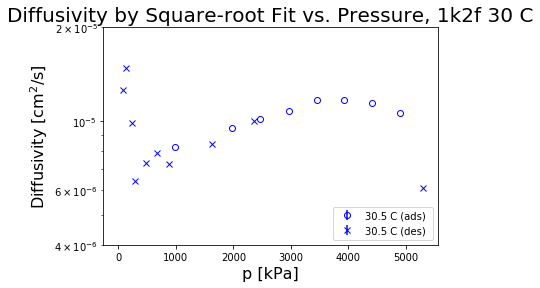

In [17]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr
# record "initial" mass extrapolated to be at beginning of pressure quench
df['M_0 (extrap) [g]'] = M_0_extrap
# save results
df.to_csv(save_folder + save_data_name)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[4E-6, 2E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

Try to fit sorption curve to 2-parameter square root (with shift in t fixed as the end of the last pressure step/start of the pressurization)

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.63e-04 cm^2/s.
t_init = 78510
t0 = 59820
w0 = -0.07474656770326155
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.28e-05 cm^2/s.
t_init = 95370
t0 = 95130
w0 = 0.007816558888578237
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.24e-05 cm^2/s.
t_init = 111360
t0 = 111090
w0 = 0.01899944660999879
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.24e-05 cm^2/s.
t_init = 126480
t0 = 126180
w0 = 0.03130268397007622
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.68e-05 cm^2/s.
t_init = 141870
t0 = 141570
w0 = 0.0434316962826199
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.71e-05 cm^2/s.
t_init = 157890
t0 = 157590
w0 = 0.05688828399767264
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 2.12e-05 cm^2/s.
t_i

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



t_init = 395910
t0 = 395760
w0 = 0.0022663523791402683


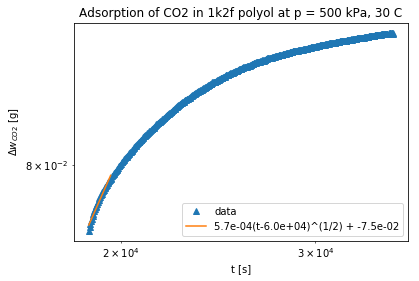

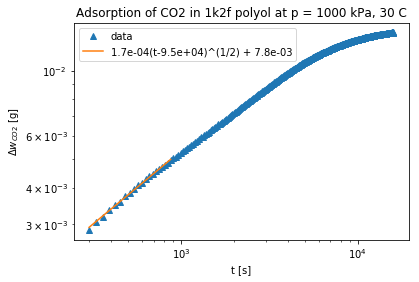

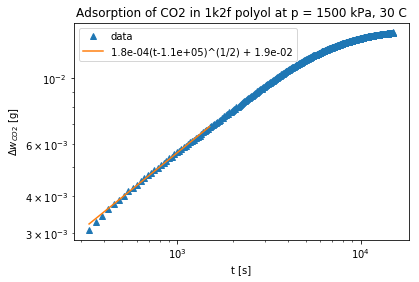

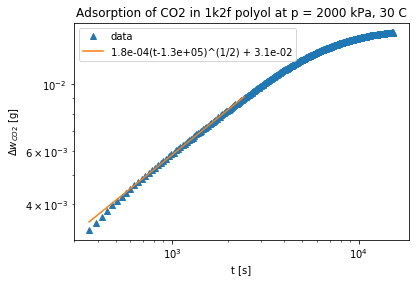

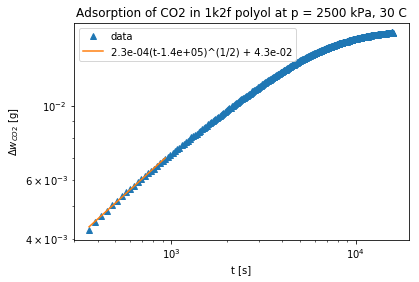

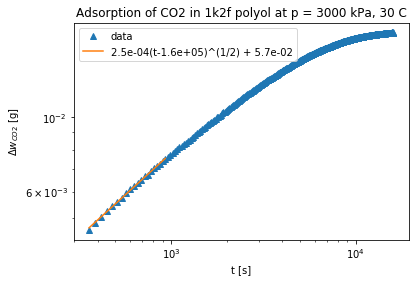

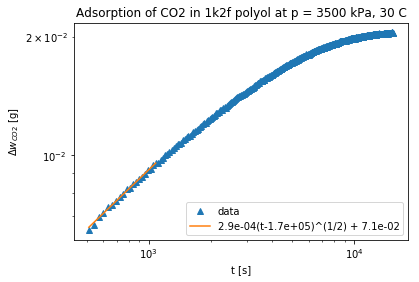

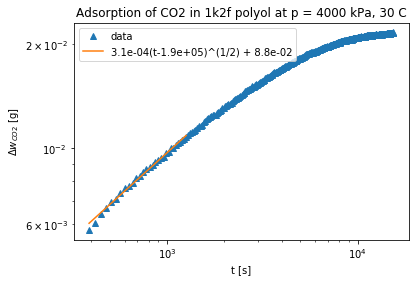

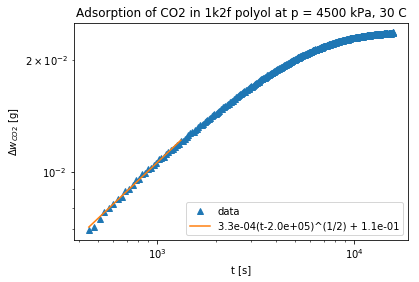

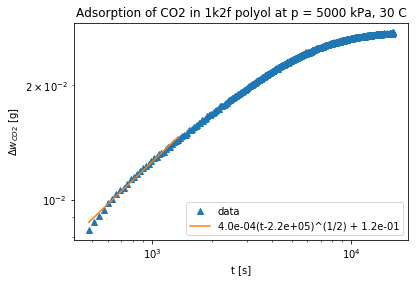

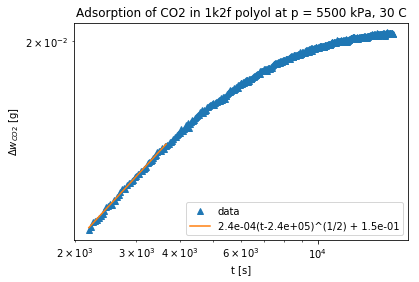

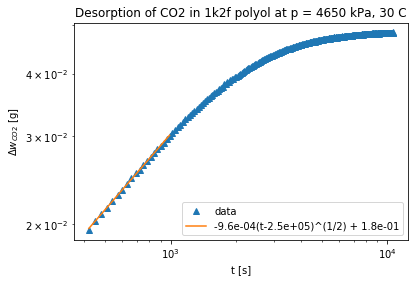

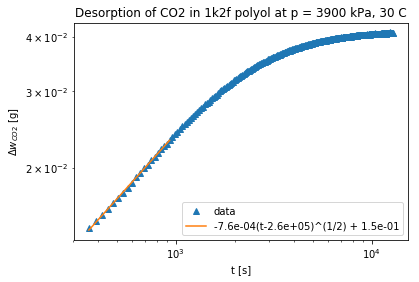

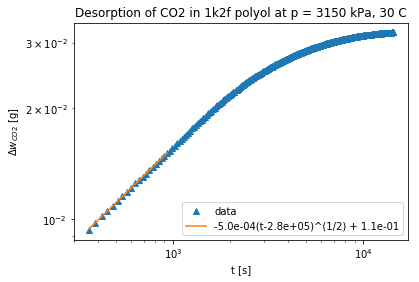

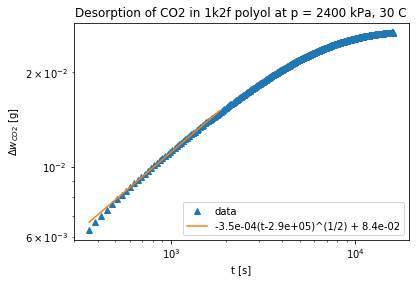

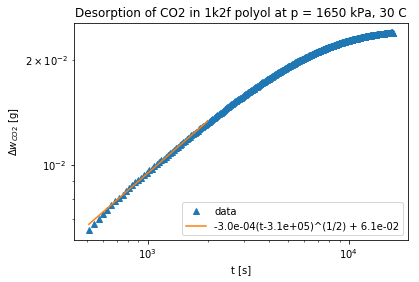

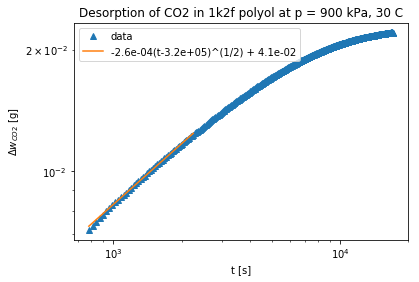

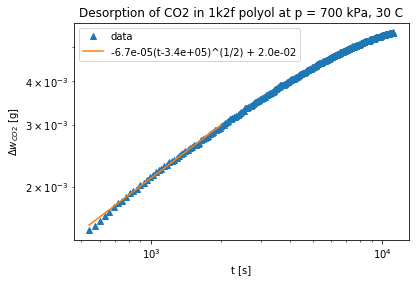

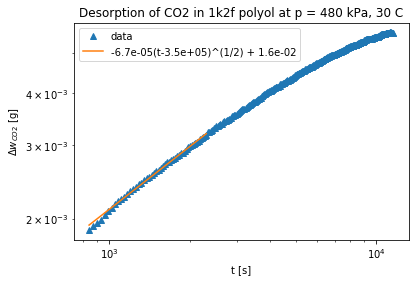

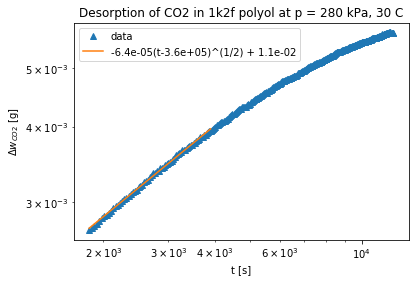

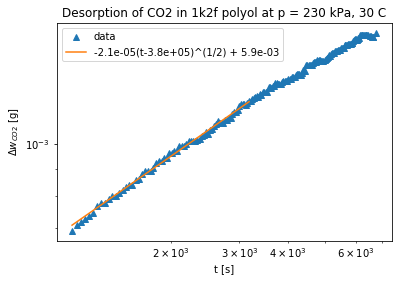

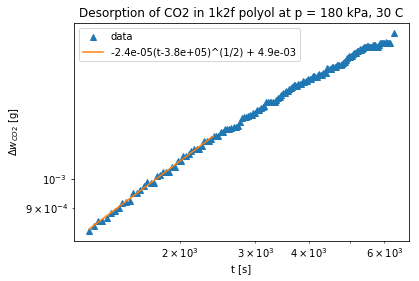

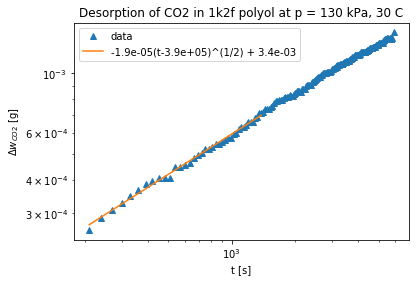

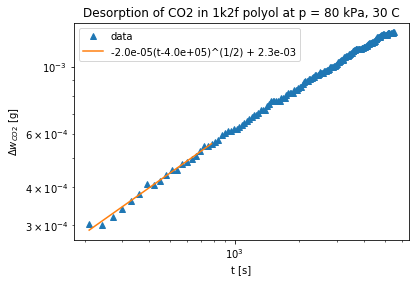

In [18]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:500, 2:1000, 3:1500, 4:2000, 5:2500, 6:3000, 7:3500, 8:4000, 9:4500,
#                        10:5000, 11:5500, 12:4650, 13:3900, 14:3150, 15:2400, 16:1650, 17:900, 18:700, 19:480, 
#                        20:280, 21:230, 22:180, 23:130, 24:80])
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = np.array([50, 60, 50, 70, 100, 50, 50, 50, 60, 60, 60, 80, 50, 50, 50, 80, 80, 80, 80, 80, 100,
                          100, 70, 70, 50]) - 30
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[2:7] = 2
i_shift[7:10] = 3
i_shift[11] = 50
i_shift[12:14] = 3
i_shift[14:] = 2

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_2param, t_mp1[:n]-t0, w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100) - t0
    w_fit = dataproc.square_root_2param(t_fit, a, w0)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = w0
    print('t_init = ' + str(t_init))
    print('t0 = ' + str(t0))
    print('w0 = ' + str(w0))

Having computed the mean diffusivities, we will save them.

#### Plot Diffusivity from Square-root Fit

Below we plot the diffusivity determined using the square-root fit as a function of the pressure

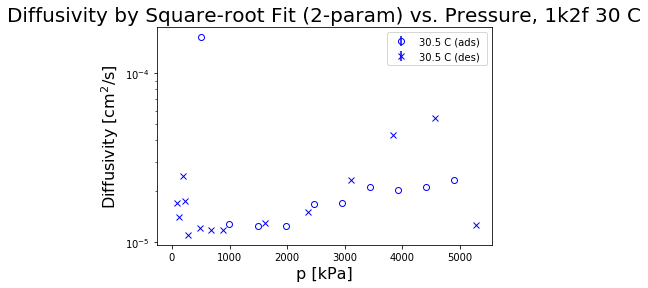

In [19]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, 0.5*np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit (2-param) vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2param_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

### Comparison of parameters for t^1/2 fitting

Below, I show the results of performing the fitting of the initial adsorption/desorption data to a $t^{1/2}$ curve for different fixed parameters of the fitting. Namely, I will test three different initial times $t_0$--(1) my best guess from above, (2) best guess minus 2 seconds, and (3) best guess plus 2 seconds--and I will compare using the estimate of $M_0$ from the $M_{\infty}$ of the previous test as the mass offset to the result from using the mass offset that yields the best fit. These plots will all correct for buoyancy using the instantaneous pressure.

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.24e-07 cm^2/s.
D_sqrt = 4.26e-07 cm^2/s.
D_sqrt = 4.28e-07 cm^2/s.
D_sqrt = 1.63e-04 cm^2/s.
D_sqrt = 1.62e-04 cm^2/s.
D_sqrt = 1.61e-04 cm^2/s.
D_sqrt = 8.32e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 2.22e-06 cm^2/s.
D_sqrt = 2.66e-06 cm^2/s.
D_sqrt = 3.30e-06 cm^2/s.

C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:698: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)



D_sqrt = 1.28e-05 cm^2/s.
D_sqrt = 1.06e-05 cm^2/s.
D_sqrt = 8.31e-06 cm^2/s.
D_sqrt = 4.60e-06 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.21e-06 cm^2/s.
D_sqrt = 4.70e-06 cm^2/s.
D_sqrt = 5.31e-06 cm^2/s.
D_sqrt = 1.24e-05 cm^2/s.
D_sqrt = 1.10e-05 cm^2/s.
D_sqrt = 9.43e-06 cm^2/s.
D_sqrt = 6.49e-06 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 6.38e-06 cm^2/s.
D_sqrt = 6.84e-06 cm^2/s.
D_sqrt = 7.37e-06 cm^2/s.
D_sqrt = 1.24e-05 cm^2/s.
D_sqrt = 1.14e-05 cm^2/s.
D_sqrt = 1.03e-05 cm^2/s.
D_sqrt = 8.28e-06 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 5.02e-06 cm^2/s.
D_sqrt = 5.86e-06 cm^2/s.
D_sqrt = 7.03e-06 cm^2/s.
D_sqrt = 1.68e-05 cm^2/s.
D_sqrt = 1.43e-05 cm^2/s.
D_sqrt = 1.17e-05 cm^2/s.
D_sqrt = 8.78e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.40e-06 cm^2/s.
D_sqrt = 5.14e-06 cm^2/s.
D_sqrt = 6.17e-06 cm^2/s.
D_sqrt = 1.71e-05 c

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


D_sqrt = 1.53e-05 cm^2/s.
D_sqrt = 1.10e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 7.62e-06 cm^2/s.
D_sqrt = 8.52e-06 cm^2/s.
D_sqrt = 9.64e-06 cm^2/s.
D_sqrt = 2.12e-05 cm^2/s.
D_sqrt = 1.88e-05 cm^2/s.
D_sqrt = 1.64e-05 cm^2/s.
D_sqrt = 1.22e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 9.32e-06 cm^2/s.
D_sqrt = 1.04e-05 cm^2/s.
D_sqrt = 1.17e-05 cm^2/s.
D_sqrt = 2.33e-05 cm^2/s.
D_sqrt = 2.08e-05 cm^2/s.
D_sqrt = 1.83e-05 cm^2/s.
D_sqrt = 1.44e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.17e-05 cm^2/s.
D_sqrt = 1.21e-05 cm^2/s.
D_sqrt = 1.25e-05 cm^2/s.
D_sqrt = 1.26e-05 cm^2/s.
D_sqrt = 1.22e-05 cm^2/s.
D_sqrt = 1.18e-05 cm^2/s.
D_sqrt = 1.22e-05 cm^2/s.
Pressure = 4650 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.39e-05 cm^2/s.
D_sqrt = 1.60e-05 cm^2/s.
D_sqrt = 1.88e-05 cm^2/s.
D_sqrt = 5.43e-05 cm^2/s.
D_sqrt = 4.69e-05 cm^2/s.
D_sqrt = 3.93e-05 cm

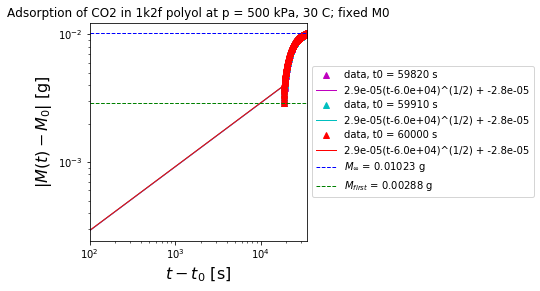

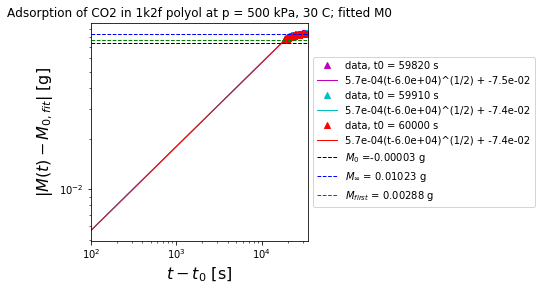

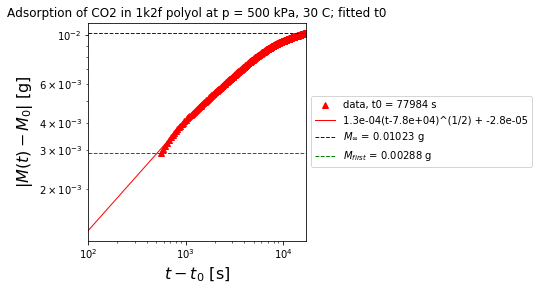

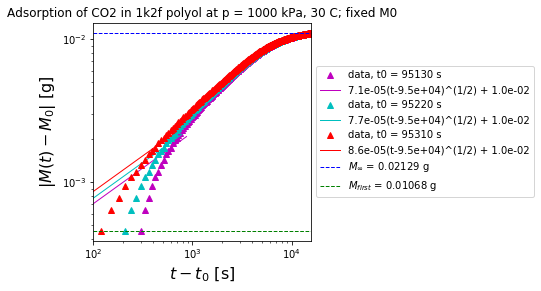

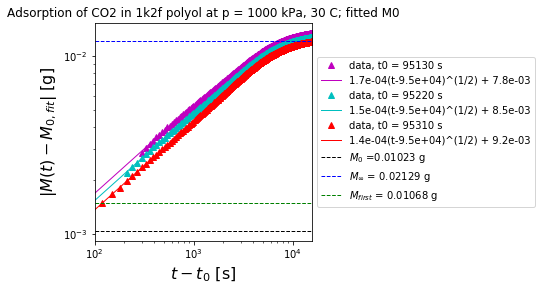

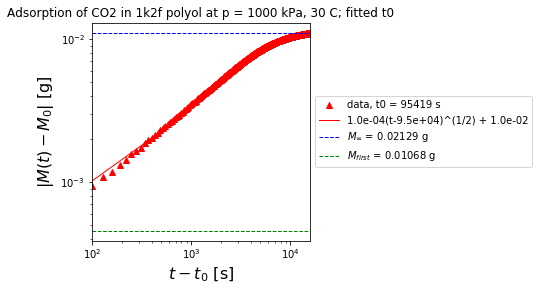

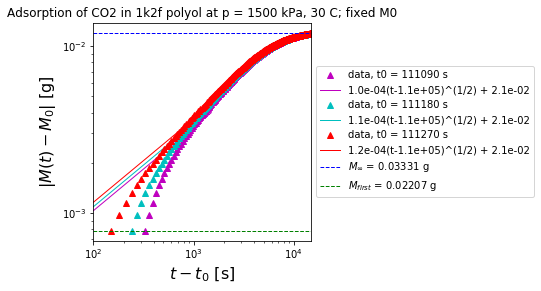

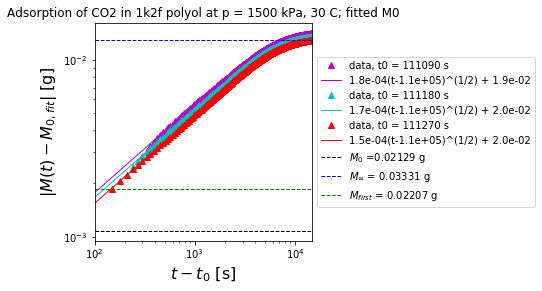

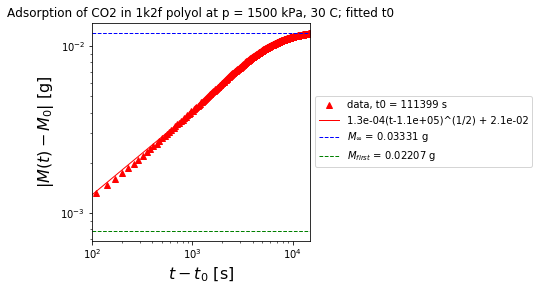

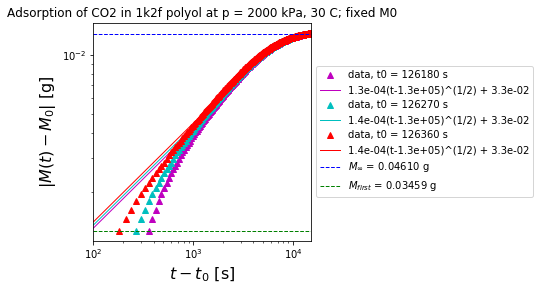

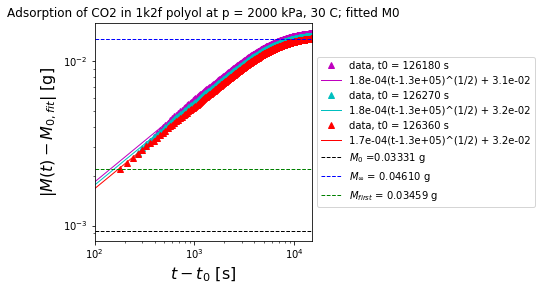

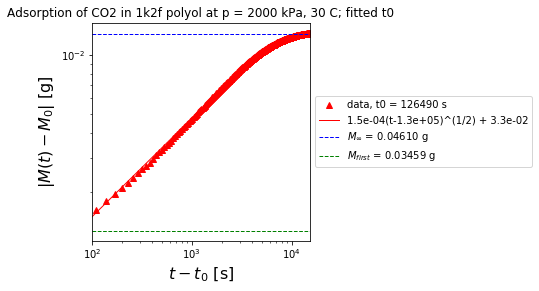

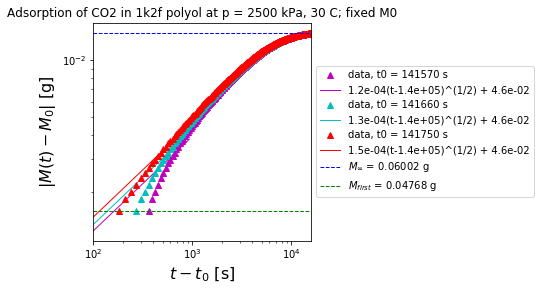

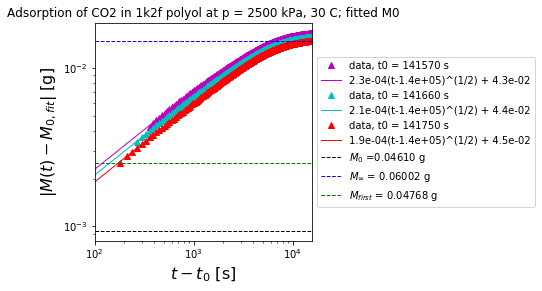

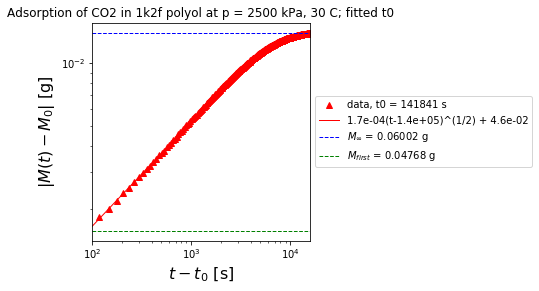

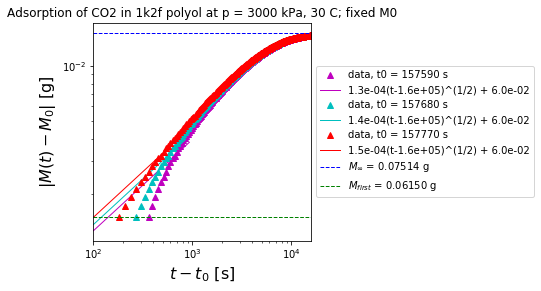

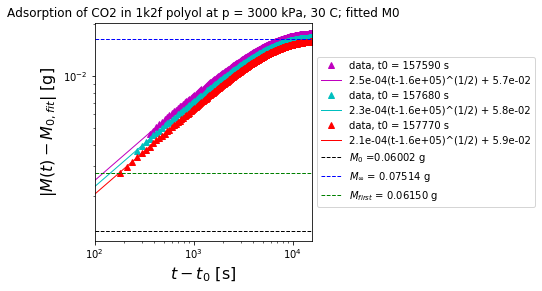

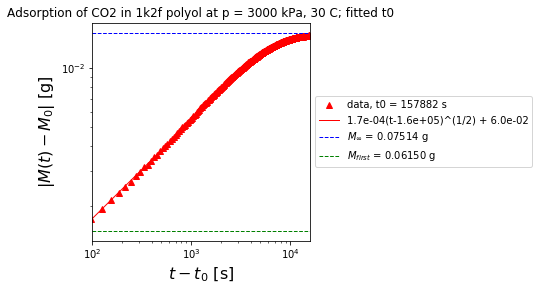

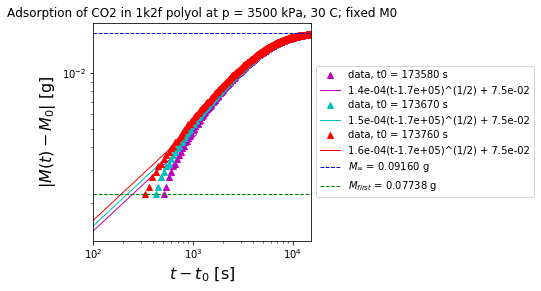

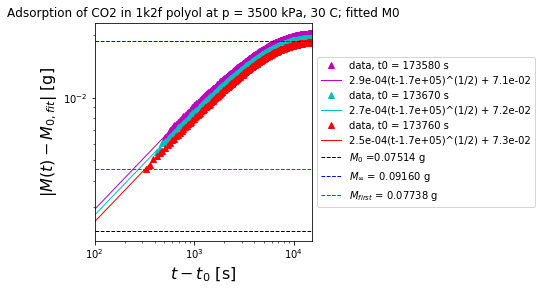

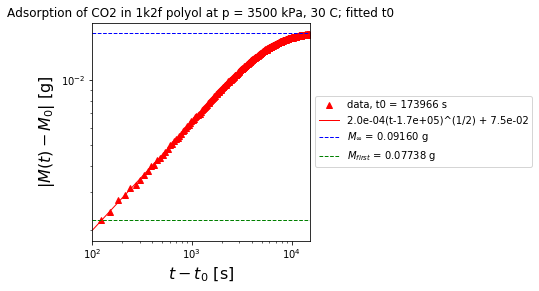

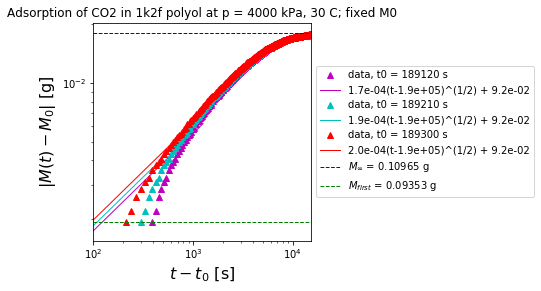

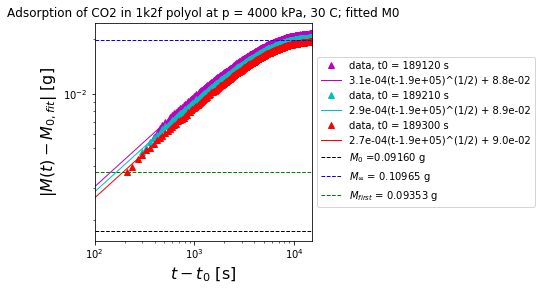

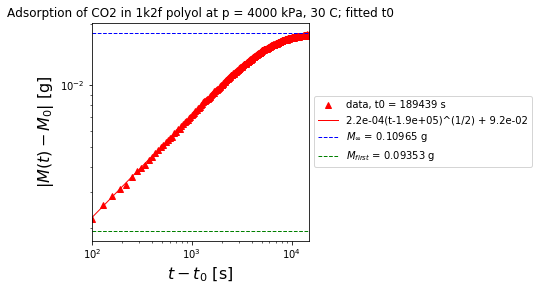

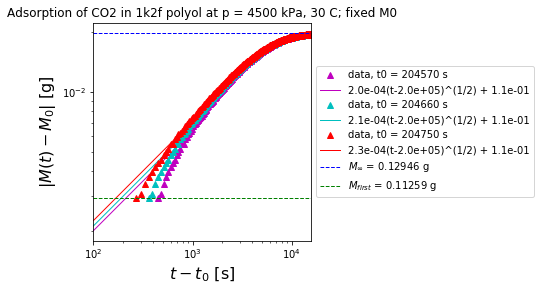

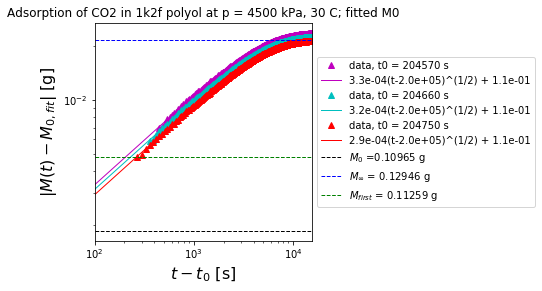

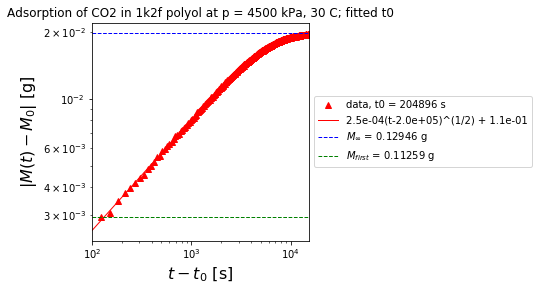

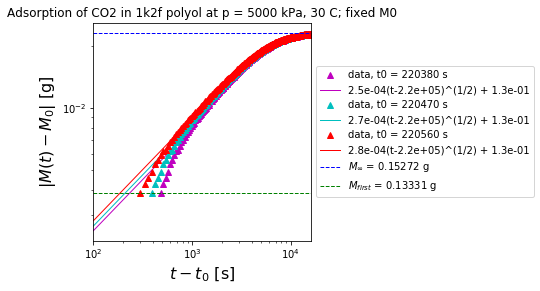

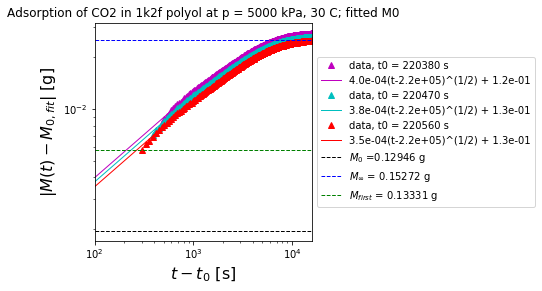

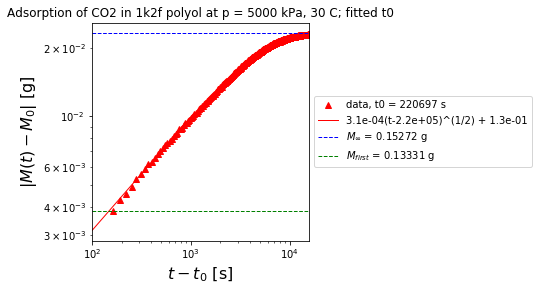

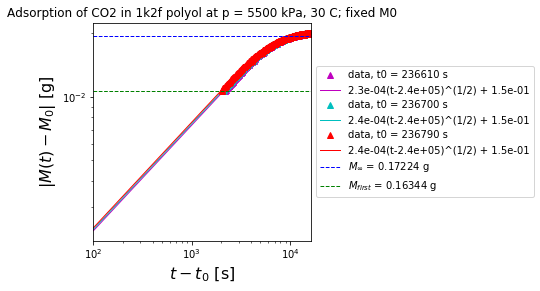

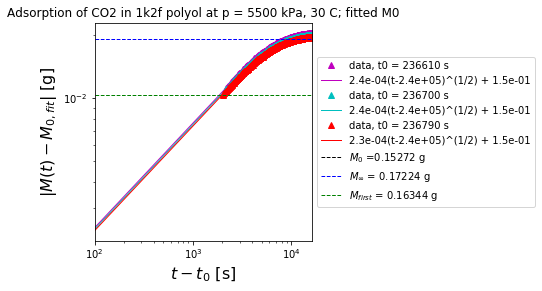

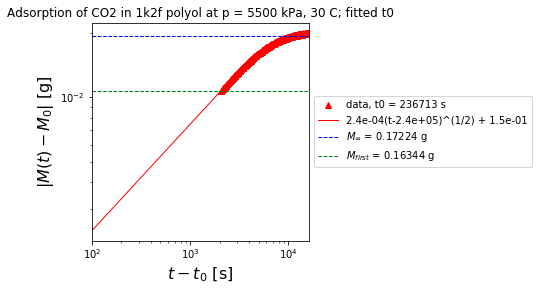

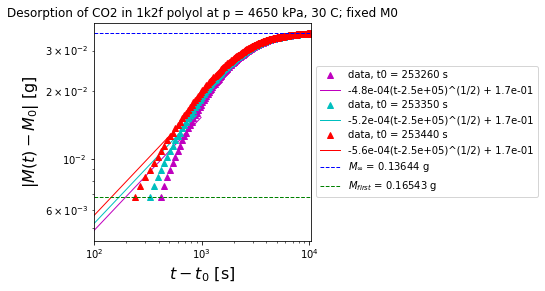

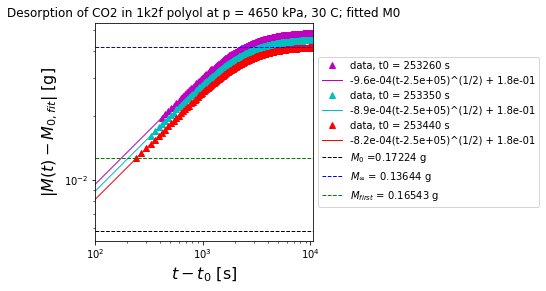

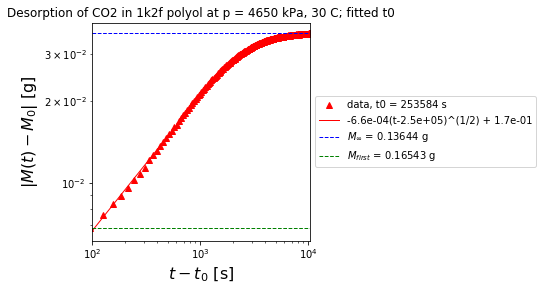

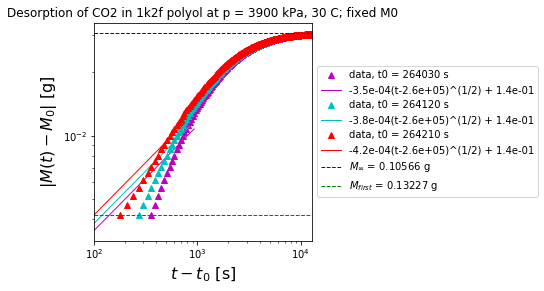

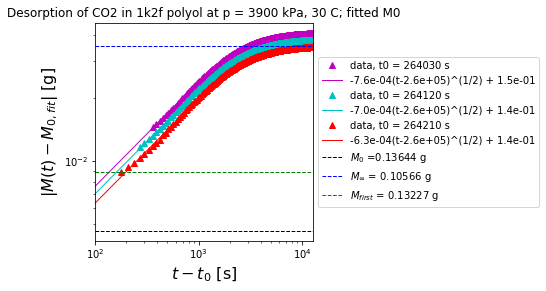

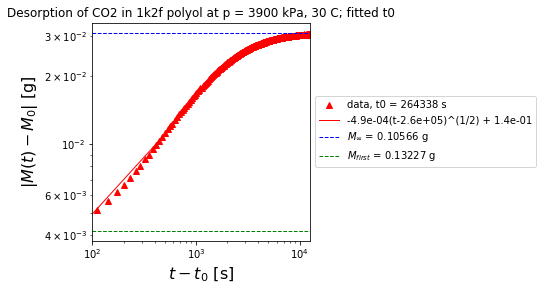

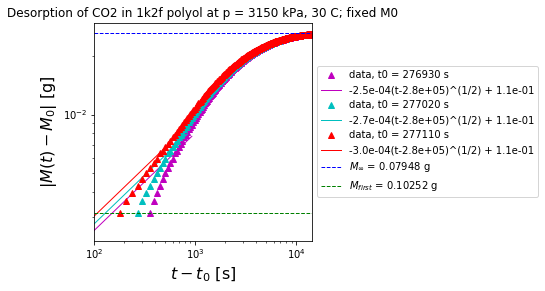

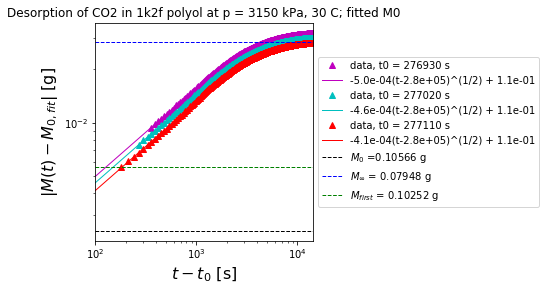

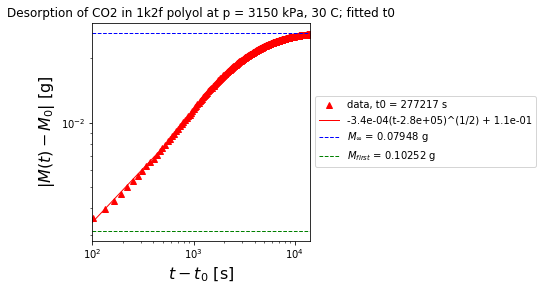

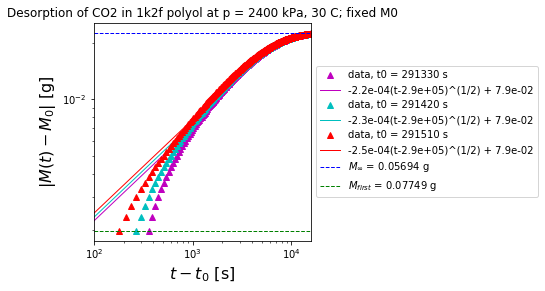

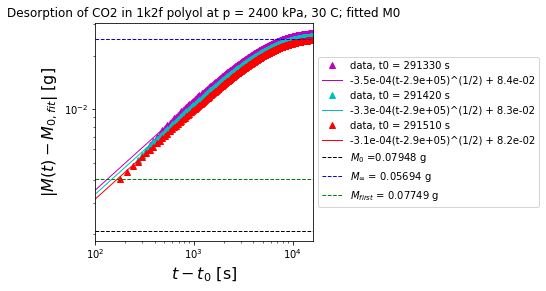

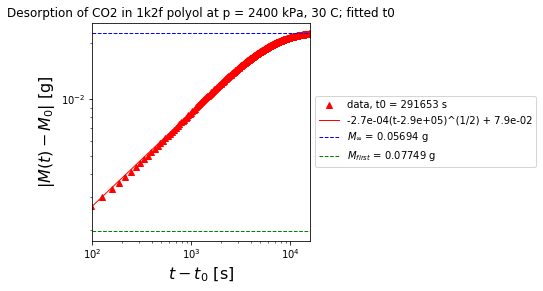

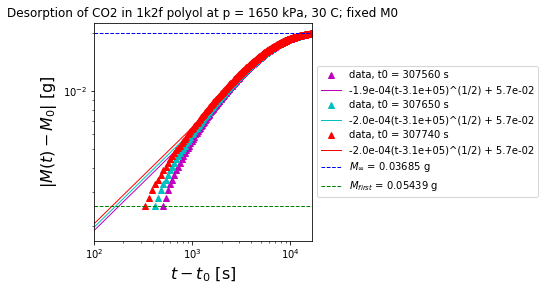

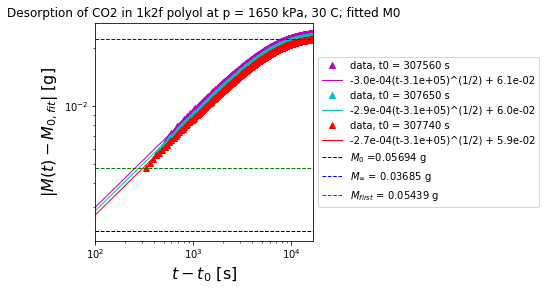

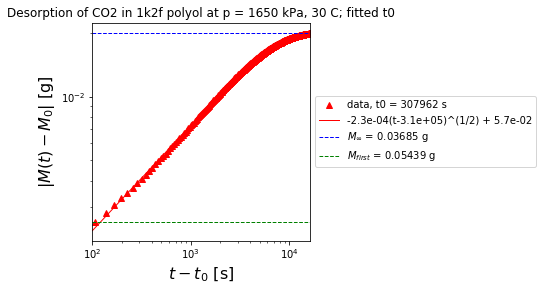

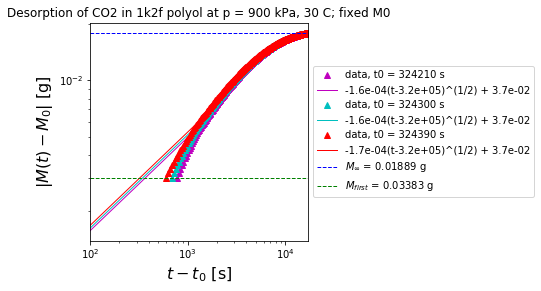

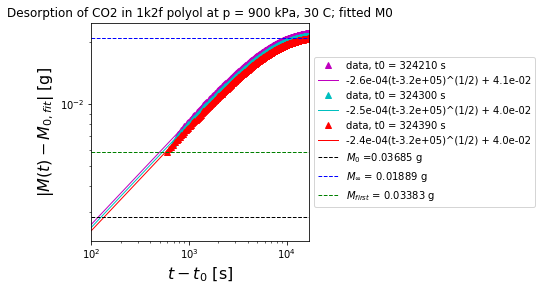

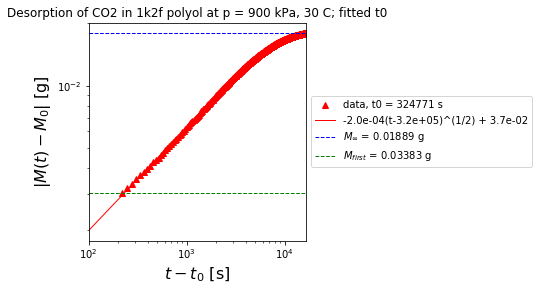

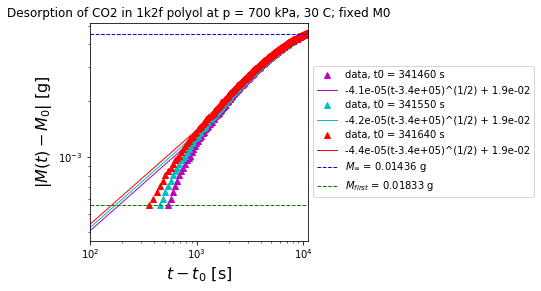

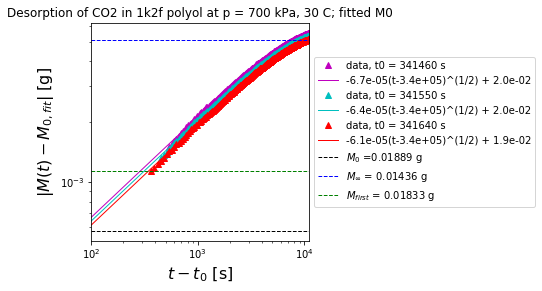

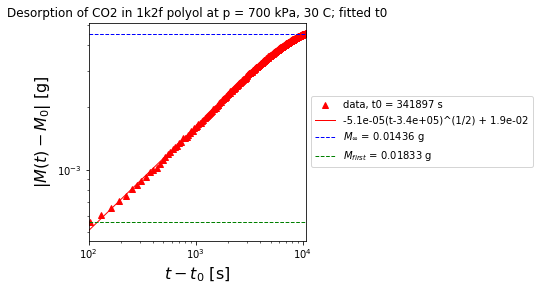

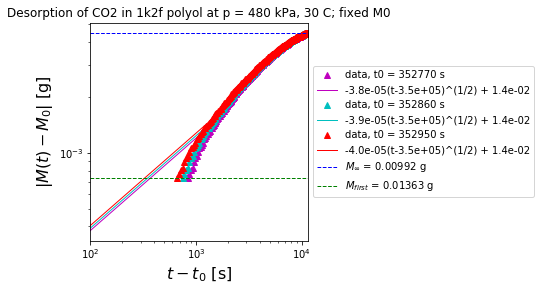

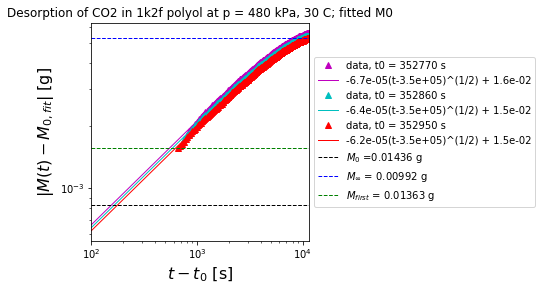

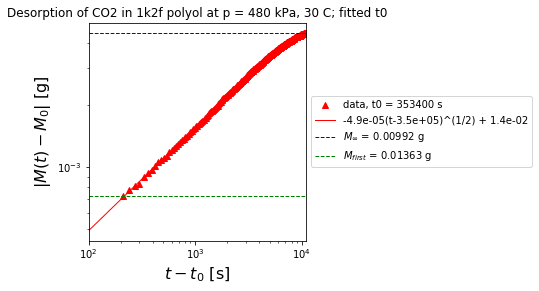

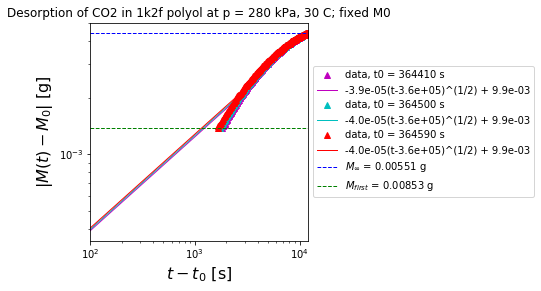

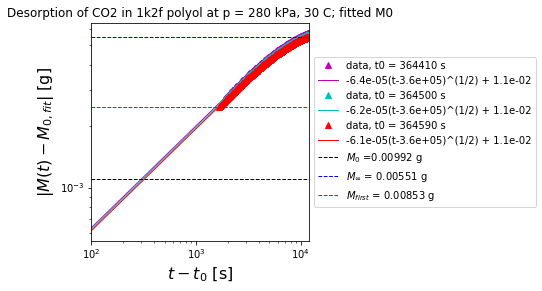

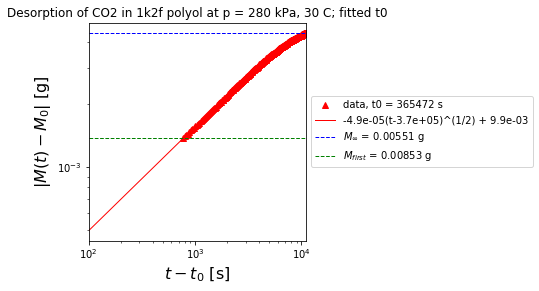

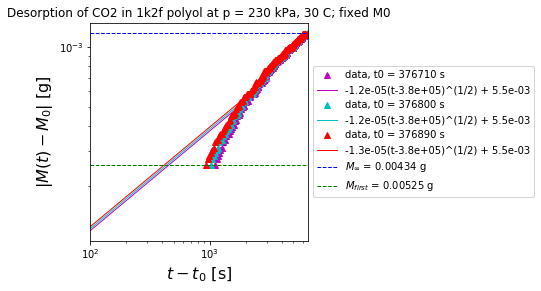

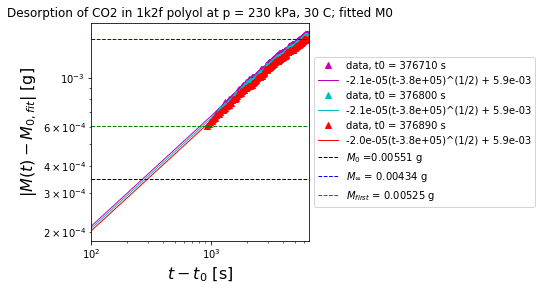

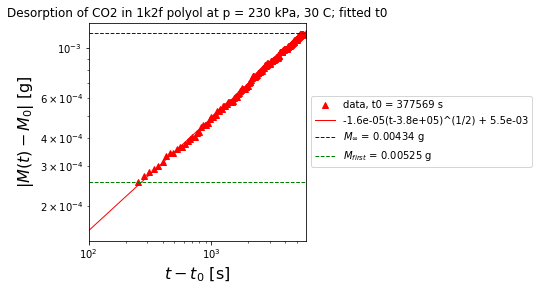

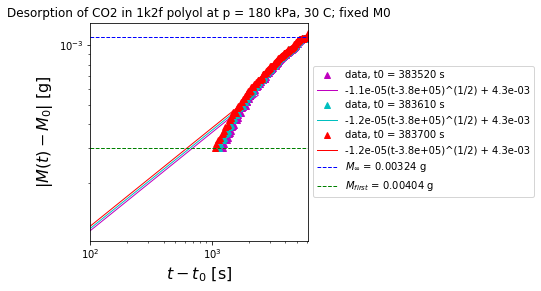

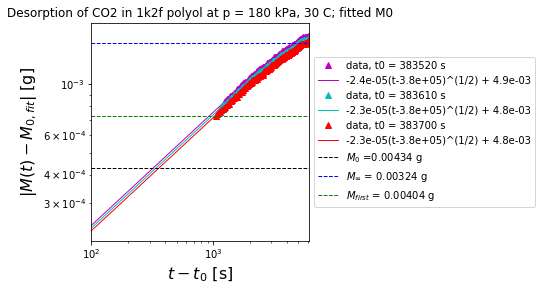

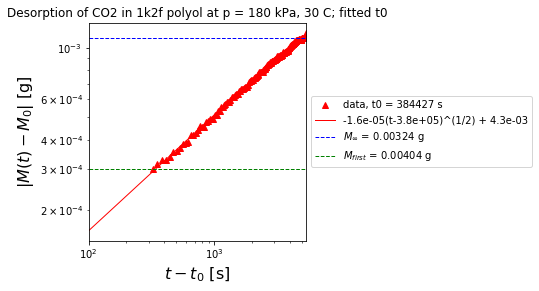

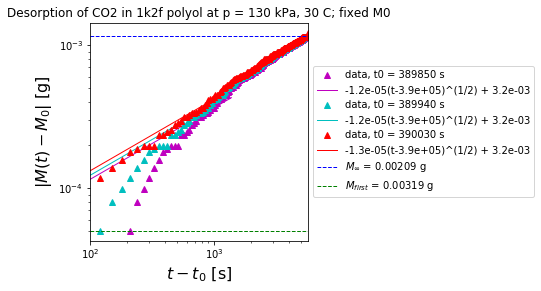

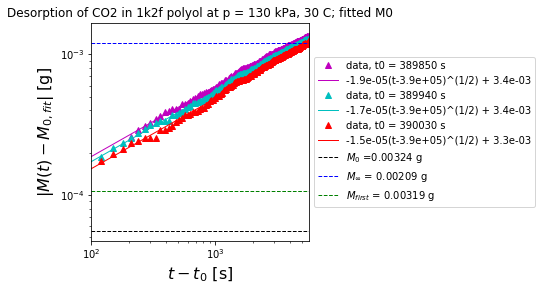

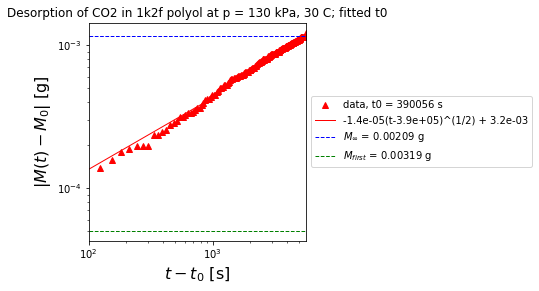

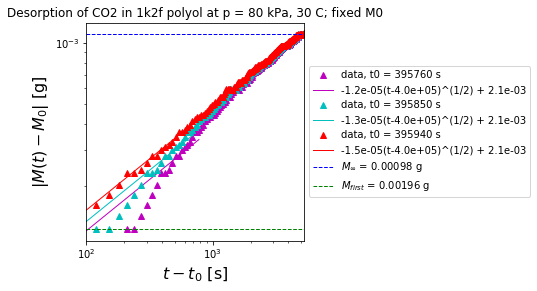

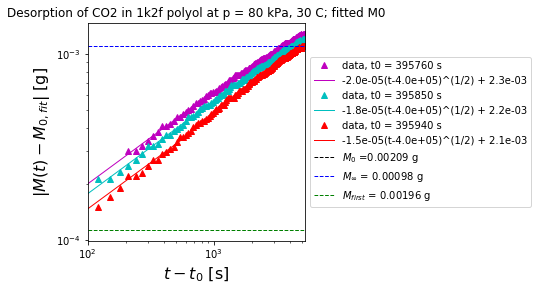

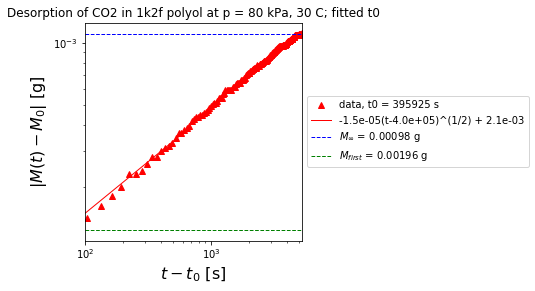

In [20]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 
reload(dataproc)
reload(plot)
# raise max number of function evaluations for fitting
maxfev = 10000

# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = np.array([50, 60, 50, 70, 100, 50, 50, 50, 60, 60, 60, 80, 50, 50, 50, 80, 80, 80, 80, 80, 100,
                          100, 70, 70, 50]) - 30
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[2:7] = 2
i_shift[7:10] = 3
i_shift[11] = 50
i_shift[12:14] = 3
i_shift[14:] = 2

# change in time between different t0's [s]
dt = 90
# lower bound of time to show on plots
t_min = 100
# bounds on change in mass
dw_min = 0.0001
dw_max = 0.05
# list of colors
color_list = ['m', 'c', 'r']
# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values when M0 is fixed and fitted
D_sqrt_arr_fixed = np.zeros([len(p_set_arr)])
D_sqrt_arr_fitted = np.zeros([len(p_set_arr)])
D_sqrt_arr_t0_fitted = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0_list = [t_grav[i_t0], t_grav[i_t0]+dt, t_grav[i_t0]+2*dt]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    
    # METHOD 1: use the M_infty from the previous pressure (an estimate of M_0) as the mass offset [FIXED]
    w0 = df['M_0 (prev) [g]'].iloc[i]
    M_0 = w0
    M_infty = df['M_infty (final) [g]'].iloc[i]
    M_first = w_gas_act[0]
    # determine if system is adsorbing or desorbing
    is_adsorbing = i <= np.argmax(p_set_arr) and i != 0
    sign = 2*(is_adsorbing-0.5)
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for j in range(len(t0_list)):
        try:
            t0 = t0_list[j]
            n = min(n_pts_sqrt, len(t_mp1)-1)
            popt, pcov = curve_fit(dataproc.square_root_1param, t_mp1[:n] - t0, w_gas_act[:n] - w0, maxfev=maxfev)
            a = popt[0]
            # generate data points for t^(1/2) fit
            t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
            w_fit = dataproc.square_root_1param(t_fit - t0, a) + w0

            # plot the result to examine the fit
            t_max = np.max(t_mp1) - t0
            stage = 'Adsorption' if is_adsorbing else 'Desorption'
            ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - w0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_0|$ [g]',
                                     marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
            ax = plot.plot_line(t_fit - t0, sign*(w_fit - w0), ax=ax, marker=None, lw=1, color=color_list[j],
                                label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
            # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
            D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
            print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
            # store result for plotting
            if j==0:
                D_sqrt_arr_fixed[i] = D_sqrt
        except:
            print("Could not perform accurate fit on data for t0 + %d" % (i*dt))
        
    # plot the mass values of interest
#     ax = plot.plot_line([t_min, t_max], [M_0-w0, M_0-w0], color='g', marker=None, lw=1, ls='--', ax=ax, label=r'$M_0$')
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-w0), sign*(M_infty-w0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-w0), sign*(M_first-w0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fixed M0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])



    # METHOD 2: Fit the mass offset
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for j in range(len(t0_list)):
        t0 = t0_list[j]
        n = min(n_pts_sqrt, len(t_mp1)-1)
        popt, pcov = curve_fit(dataproc.square_root_2param, t_mp1[:n] - t0, w_gas_act[:n], maxfev=maxfev)
        a = popt[0]
        w0 = popt[1]
        # generate data points for t^(1/2) fit
        t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
        w_fit = dataproc.square_root_2param(t_fit - t0, a, w0)

        # plot the result to examine the fit
        t_max = np.max(t_mp1) - t0
        stage = 'Adsorption' if is_adsorbing else 'Desorption'
        ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - w0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_{0,fit}|$ [g]',
                                 marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
        ax = plot.plot_line(t_fit - t0, sign*(w_fit - w0), ax=ax, marker=None, lw=1, color=color_list[j],
                            label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
        # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
        D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
        print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
        # store result for plotting
        if j==0:
            D_sqrt_arr_fitted[i] = D_sqrt

        
    # plot the mass values of interest
    ax = plot.plot_line([t_min, t_max], [sign*(M_0-w0), sign*(M_0-w0)], color='k', marker=None, lw=1, ls='--', ax=ax, 
                        label=r'$M_0$' + ' =%.5f g' % M_0)
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-w0), sign*(M_infty-w0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-w0), sign*(M_first-w0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fitted M0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])


    # METHOD 3: Fit the initial time
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_2param_t0_fit, t_mp1[:n], w_gas_act[:n] - M_0, maxfev=maxfev)
    a = popt[0]
    t0 = popt[1]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
    w_fit = dataproc.square_root_2param_t0_fit(t_fit, a, t0) + M_0

    # plot the result to examine the fit
    t_max = np.max(t_mp1) - t0
    stage = 'Adsorption' if is_adsorbing else 'Desorption'
    ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - M_0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_0|$ [g]',
                             marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
    ax = plot.plot_line(t_fit - t0, sign*(w_fit - M_0), ax=ax, marker=None, lw=1, color=color_list[j],
                        label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=M_0, t0=t0))
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result for plotting
    D_sqrt_arr_t0_fitted[i] = D_sqrt

        
    # plot the mass values of interest
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-M_0), sign*(M_infty-M_0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-M_0), sign*(M_first-M_0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fitted t0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])

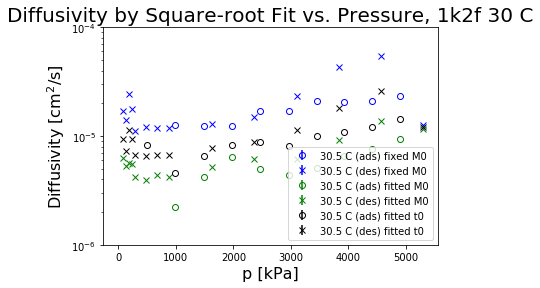

In [21]:
# Plot diffusivity vs. pressure for fixed M_0 and t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_fitted, np.zeros([len(D_sqrt_arr_fitted)]), p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='fixed M0',
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# Plot diffusivity vs. pressure for fitted M_0 and fixed t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_fixed, np.zeros([len(D_sqrt_arr_fixed)]), p_set_arr, T, ax=ax, color='g',
                                label_tag='fitted M0') 
# Plot diffusivity vs. pressure for fixed M_0 and fitted t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_t0_fitted, np.zeros([len(D_sqrt_arr_t0_fitted)]), p_set_arr, T, ax=ax, 
                                 color='k', label_tag='fitted t0') 

save_plots=False
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fixed_fitted_t0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

***DEMONSTRATE THAT CHANGE IN H_SAMP IS NEGLIGIBLE (HOW SMALL?)***

Pressure = 0 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
D_exp = 3.24e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_exp = 6.01e-06 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_exp = 7.53e-06 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_exp = 7.07e-06 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_exp = 7.97e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_exp = 9.42e-06 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_exp = 1.02e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_exp = 1.24e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_exp = 1.23e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_exp = 1.12e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_exp = 1.17e-05 cm^2/s.
Pressure = 4650 kPa.
Rejected 1 outliers.
D_exp = 2.20e-05 cm^2/s.
Pressure = 3900 kPa.
Rejected 1 outliers.
D_exp = 1.48e-05 cm^2/s.
Pressure = 3150 kPa.
Rejected 1 outliers.
D_exp = 9.08e-06 cm^2/s.
Pressure = 2400 kPa.
Rej

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


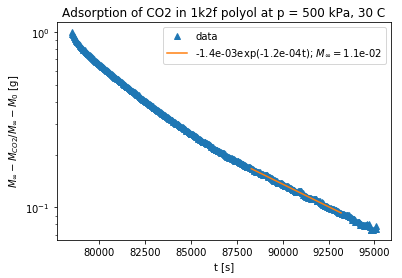

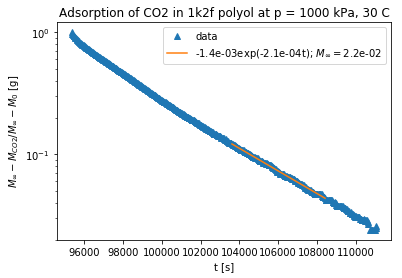

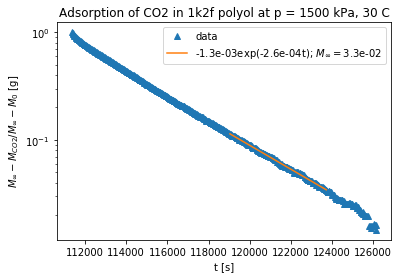

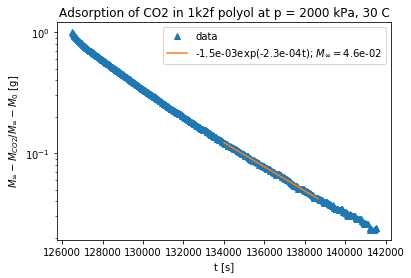

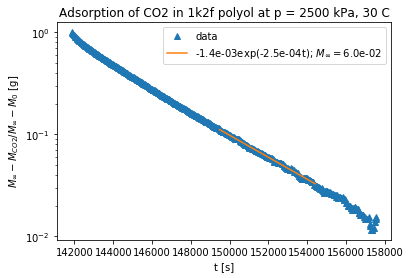

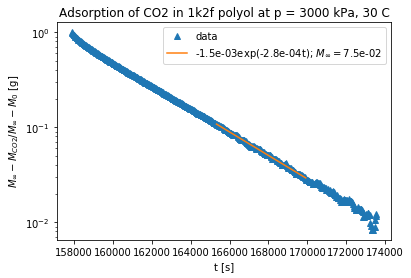

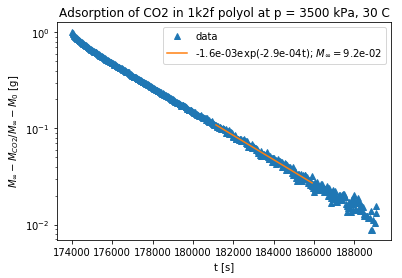

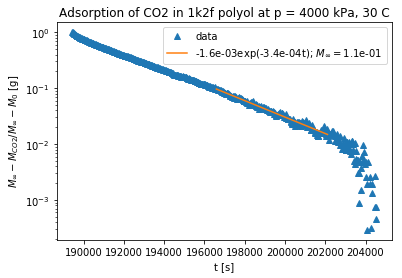

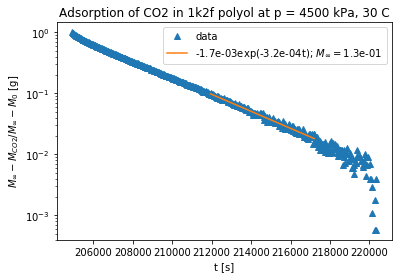

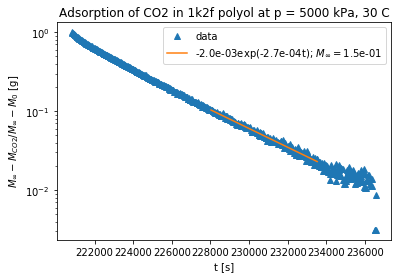

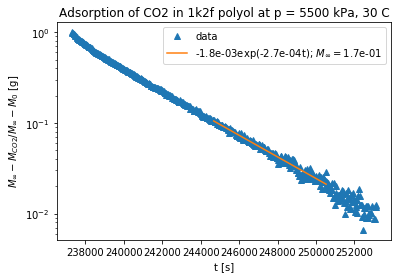

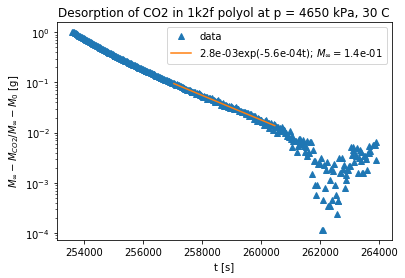

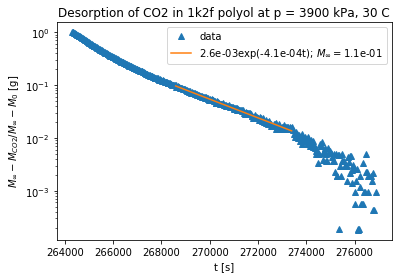

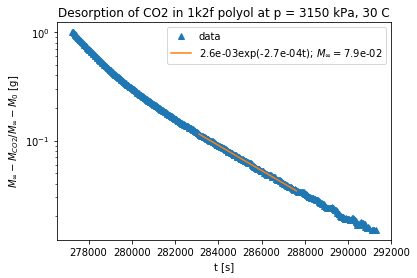

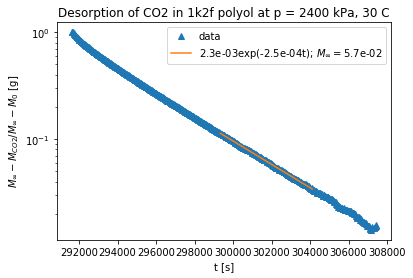

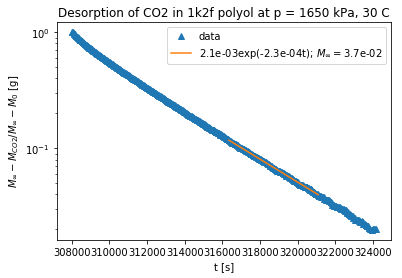

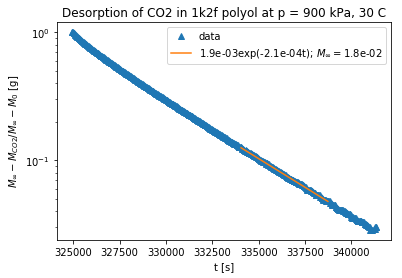

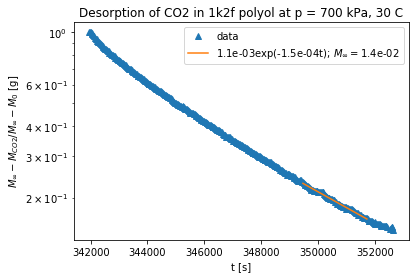

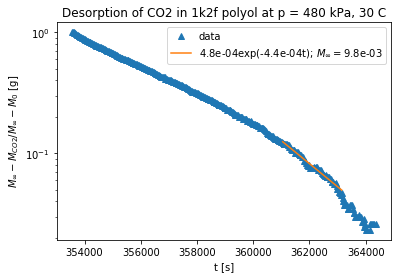

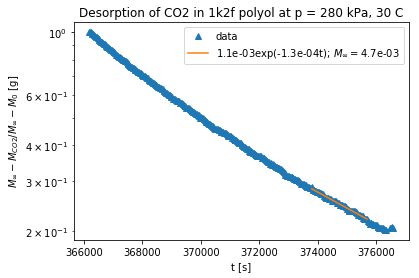

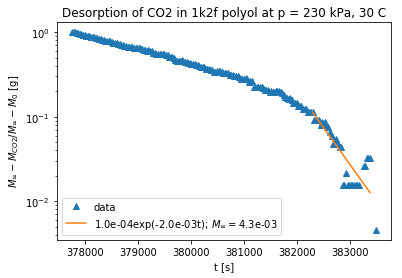

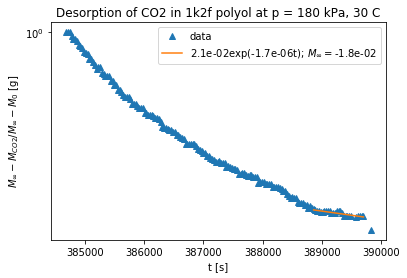

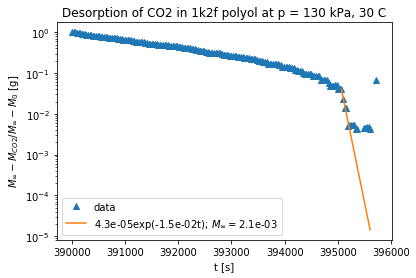

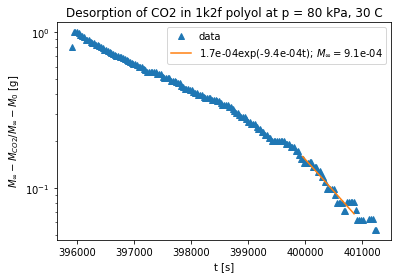

In [22]:
# initalize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    is_adsorbing = (i <= np.argmax(p_set_arr)) and p_set != 0

    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue

#     if p_set == 0 or p_set == 50:
#         continue
        
    #### NEW ####
    # normalize
    if is_adsorbing:
        M_infty = np.max(w_gas_act)
        M_0 = np.min(w_gas_act)
    else:
        M_infty = np.min(w_gas_act)
        M_0 = np.max(w_gas_act)    
    w_gas_norm = np.abs((M_infty - w_gas_act) / (M_infty - M_0))
    i_50 = np.where(w_gas_norm > 0.1)[0][-1]
    i_90 = np.where(w_gas_norm > 0.02)[0][-1]
    #############
    
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_50:i_90]-t_mp1[i_50], 
                           w_gas_act[i_50:i_90], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[i_50], t_mp1[i_90], 100) - t_mp1[i_50]
    w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)
    
    # plot the result to examine the fit
    normalization = 1 / np.max(np.abs(c - w_gas_act))
    w_gas_2_plot = normalization*np.abs(c - w_gas_act)
    w_fit_2_plot = normalization*np.abs(c - w_gas_fit)
    
    #Plot diffusivity vs. p    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy(t_mp1, w_gas_2_plot, '^', label='data')
    ax.semilogy(t_fit + t_mp1[i_50], w_fit_2_plot, '-', label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}' \
                .format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$M_{\infty} - M_{CO2} / M_{\infty} - M_0$ [g]')
    ax.tick_params(axis='y', which='minor', left=True)
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

Having computed the mean diffusivities, we will save them.

In [23]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

#### Plot Diffusivity for Exponential Fit

We now plot the diffusivity as a function of pressure found using the exponential fit of the last data points.

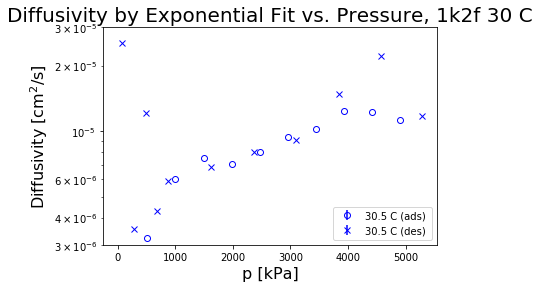

In [24]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([3E-6,3E-5])
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Diffusivity Estimated by Square-root and Exponential Methods

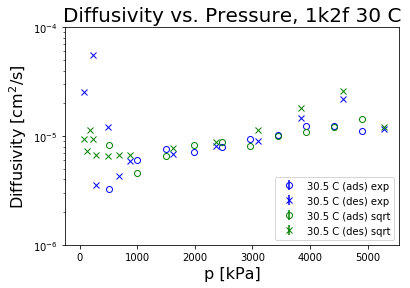

In [25]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', label_tag='exp',
                                 title='Diffusivity vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_t0_fitted, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, ax=ax, color='g', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='sqrt')
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = True
if save_plots:
    plt.savefig(save_folder + 'diff_exp_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

In [26]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

## Save Metadata

Last we will save the parameters of this analysis (we put it last so we can decide not to overwrite the previous parameters if the analysis does not look worth saving). These metadata will also include overall constants for the system like Henry's constant and the overall mass loss of the sample (if the data are available to measure this).

In [27]:
# henry_const = dataproc.compute_henry_const() # how many data points to include in linear fit?
# mass_loss = estimate_mass_loss() # maybe fit polynomial to adsorption and desorption, subtract difference?

# import csv

# metadict = dataproc.load_metadict(henry_const, s_henry_const, mass_loss, s_mass_loss, w_samp_atm, s_w_samp_atm,
#                                  w_samp_zero, s_w_samp_zero, rho_samp_atm, s_rho_samp_atm, rho_samp_zero, s_rho_samp_zero,
#                                  v_samp_atm, s_v_samp_atm, v_samp_zero, s_v_samp_zero, n_adsa, n_p_eq, v_drop_atm, s_v_drop_atm,
#                                  v_ref_he, s_v_ref_he, diam_cruc, s_diam_cruc, p_thresh_frac, T, TARE)
# with open(save_folder + save_file[:-4] + '_metadata.csv', 'w') as f:
#     for key in metadict.keys():
#         f.write('%s,%s\n'%(key,metadict[key]))